# Initialization

## Imports

In [1]:
using Base.Threads, SparseArrays, KrylovKit, LinearAlgebra, Plots, DataFrames, LsqFit, ProgressMeter, JLD, Profile, BenchmarkTools, Einsum, LaTeXStrings, Alert, Statistics

## Functions

In [2]:
function idx(i,j,k)
    """
    Return a unique index for the site with coordinate (i,j) in layer k.
    """
    return (i-1)*L*2 + (j-1)*2 + k
end;

function idx_inv(idx_val)
    """
    Return the coordinate (i,j) and layer k of a given index.
    """
    k = (idx_val - 1) % 2 + 1
    j = ((idx_val - k) % (L * 2)) ÷ 2 + 1
    i = (idx_val - (j-1)*2 - k) ÷ (L * 2) + 1
    return i, j, k
end;

In [3]:
function rot(origin, point, rot_angle)
    """
    Rotate a point counterclockwise by a given angle around a given origin.
    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point
    
    qx = ox + cos(rot_angle) * (px - ox) - sin(rot_angle) * (py - oy)
    qy = oy + sin(rot_angle) * (px - ox) + cos(rot_angle) * (py - oy)
    
    return [Int(round(qx)), Int(round(qy))]
end;

In [4]:
function hamiltonian_obc(L,m,δϕ)
    """
    Construct the first-quantized Hamiltonian of the QWZ model on an LxL square lattice 
    with open boundary conditions. m gives the strength of the layer-dependent on-site 
    potential and δϕ∈[0,2π] gives the flux inserted at the central plaquette.
    """
    rows = []
    cols = []
    data = Vector{Complex{Float64}}()
    
    for i in 1:L
        for j in 1:L
            # Terms 1 (Z)
            push!(rows,idx(i,j,2)); push!(cols,idx(i,j,2)); push!(data,m)
            push!(rows,idx(i,j,1)); push!(cols,idx(i,j,1)); push!(data,-m)
            
            if (i<L) 
                if (j>Int(L/2+1/2))&&(i==Int(L/2+1/2))
                    # Terms 2 (Z)
                    push!(rows,idx(i+1,j,2)); push!(cols,idx(i,j,2)); push!(data,1*exp(-im*δϕ));
                    push!(cols,idx(i+1,j,2)); push!(rows,idx(i,j,2)); push!(data,1*exp(im*δϕ));

                    push!(rows,idx(i+1,j,1)); push!(cols,idx(i,j,1)); push!(data,-1*exp(-im*δϕ));
                    push!(cols,idx(i+1,j,1)); push!(rows,idx(i,j,1)); push!(data,-1*exp(im*δϕ));

                    # Terms 3 (iX)
                    push!(rows,idx(i+1,j,2)); push!(cols,idx(i,j,1)); push!(data,im*exp(-im*δϕ));
                    push!(cols,idx(i+1,j,2)); push!(rows,idx(i,j,1)); push!(data,-im*exp(im*δϕ));

                    push!(rows,idx(i+1,j,1)); push!(cols,idx(i,j,2)); push!(data,im*exp(-im*δϕ));
                    push!(cols,idx(i+1,j,1)); push!(rows,idx(i,j,2)); push!(data,-im*exp(im*δϕ));
                else
                    # Terms 2 (Z)
                    push!(rows,idx(i+1,j,2)); push!(cols,idx(i,j,2)); push!(data,1);
                    push!(cols,idx(i+1,j,2)); push!(rows,idx(i,j,2)); push!(data,1);

                    push!(rows,idx(i+1,j,1)); push!(cols,idx(i,j,1)); push!(data,-1);
                    push!(cols,idx(i+1,j,1)); push!(rows,idx(i,j,1)); push!(data,-1);

                    # Terms 3 (iX)
                    push!(rows,idx(i+1,j,2)); push!(cols,idx(i,j,1)); push!(data,im);
                    push!(cols,idx(i+1,j,2)); push!(rows,idx(i,j,1)); push!(data,-im);

                    push!(rows,idx(i+1,j,1)); push!(cols,idx(i,j,2)); push!(data,im);
                    push!(cols,idx(i+1,j,1)); push!(rows,idx(i,j,2)); push!(data,-im);
                end
            end
            
            if (j<L) 
                # Terms 4 (Z)
                push!(rows,idx(i,j+1,2)); push!(cols,idx(i,j,2)); push!(data,1);
                push!(cols,idx(i,j+1,2)); push!(rows,idx(i,j,2)); push!(data,1);

                push!(rows,idx(i,j+1,1)); push!(cols,idx(i,j,1)); push!(data,-1);
                push!(cols,idx(i,j+1,1)); push!(rows,idx(i,j,1)); push!(data,-1);

                # Terms 5 (iY)
                push!(rows,idx(i,j+1,2)); push!(cols,idx(i,j,1)); push!(data,1);
                push!(cols,idx(i,j+1,2)); push!(rows,idx(i,j,1)); push!(data,1);

                push!(rows,idx(i,j+1,1)); push!(cols,idx(i,j,2)); push!(data,-1);
                push!(cols,idx(i,j+1,1)); push!(rows,idx(i,j,2)); push!(data,-1);
            end
        end
    end
    
    H = SparseArrays.sparse(rows, cols, data, 2*L^2, 2*L^2)

    return H
end;

In [5]:
function hamiltonian_pbc(L,m,δϕ)
    """
    Construct the first-quantized Hamiltonian of the QWZ model on an LxL square lattice 
    with periodic boundary conditions. m gives the strength of the layer-dependent on-site 
    potential and δϕ∈[0,2π] gives the flux inserted at the central plaquette.
    """
    rows = []
    cols = []
    data = Vector{Complex{Float64}}()
    
    for i in 1:L
        for j in 1:L
            # Terms 1 (Z)
            push!(rows,idx(i,j,2)); push!(cols,idx(i,j,2)); push!(data,m)
            push!(rows,idx(i,j,1)); push!(cols,idx(i,j,1)); push!(data,-m)
            
            
            if (j>Int(L/2))&&(i==Int(L/2))
                # Terms 2 (Z)
                push!(rows,idx(mod1(i+1,L),j,2)); push!(cols,idx(i,j,2)); push!(data,1*exp(-im*δϕ));
                push!(cols,idx(mod1(i+1,L),j,2)); push!(rows,idx(i,j,2)); push!(data,1*exp(im*δϕ));

                push!(rows,idx(mod1(i+1,L),j,1)); push!(cols,idx(i,j,1)); push!(data,-1*exp(-im*δϕ));
                push!(cols,idx(mod1(i+1,L),j,1)); push!(rows,idx(i,j,1)); push!(data,-1*exp(im*δϕ));

                # Terms 3 (iX)
                push!(rows,idx(mod1(i+1,L),j,2)); push!(cols,idx(i,j,1)); push!(data,im*exp(-im*δϕ));
                push!(cols,idx(mod1(i+1,L),j,2)); push!(rows,idx(i,j,1)); push!(data,-im*exp(im*δϕ));

                push!(rows,idx(mod1(i+1,L),j,1)); push!(cols,idx(i,j,2)); push!(data,im*exp(-im*δϕ));
                push!(cols,idx(mod1(i+1,L),j,1)); push!(rows,idx(i,j,2)); push!(data,-im*exp(im*δϕ));
            else
                # Terms 2 (Z)
                push!(rows,idx(mod1(i+1,L),j,2)); push!(cols,idx(i,j,2)); push!(data,1);
                push!(cols,idx(mod1(i+1,L),j,2)); push!(rows,idx(i,j,2)); push!(data,1);

                push!(rows,idx(mod1(i+1,L),j,1)); push!(cols,idx(i,j,1)); push!(data,-1);
                push!(cols,idx(mod1(i+1,L),j,1)); push!(rows,idx(i,j,1)); push!(data,-1);

                # Terms 3 (iX)
                push!(rows,idx(mod1(i+1,L),j,2)); push!(cols,idx(i,j,1)); push!(data,im);
                push!(cols,idx(mod1(i+1,L),j,2)); push!(rows,idx(i,j,1)); push!(data,-im);

                push!(rows,idx(mod1(i+1,L),j,1)); push!(cols,idx(i,j,2)); push!(data,im);
                push!(cols,idx(mod1(i+1,L),j,1)); push!(rows,idx(i,j,2)); push!(data,-im);
            end
            
            # Terms 4 (Z)
            push!(rows,idx(i,mod1(j+1,L),2)); push!(cols,idx(i,j,2)); push!(data,1);
            push!(cols,idx(i,mod1(j+1,L),2)); push!(rows,idx(i,j,2)); push!(data,1);

            push!(rows,idx(i,mod1(j+1,L),1)); push!(cols,idx(i,j,1)); push!(data,-1);
            push!(cols,idx(i,mod1(j+1,L),1)); push!(rows,idx(i,j,1)); push!(data,-1);

            # Terms 5 (iY)
            push!(rows,idx(i,mod1(j+1,L),2)); push!(cols,idx(i,j,1)); push!(data,1);
            push!(cols,idx(i,mod1(j+1,L),2)); push!(rows,idx(i,j,1)); push!(data,1);

            push!(rows,idx(i,mod1(j+1,L),1)); push!(cols,idx(i,j,2)); push!(data,-1);
            push!(cols,idx(i,mod1(j+1,L),1)); push!(rows,idx(i,j,2)); push!(data,-1);
        end
    end
    
    H = SparseArrays.sparse(rows, cols, data, 2*L^2, 2*L^2)

    return H
end;

In [83]:
function arrow_triangle_mid!(p, x1, y1, x2, y2; color=:black, w=0.15)
    dx = x2 - x1
    dy = y2 - y1
    r = sqrt(dx^2 + dy^2)
    r == 0 && return

    # unit direction
    ux = dx / r
    uy = dy / r

    # perpendicular
    px = -uy
    py = ux

    # midpoint
    mx = (x1 + x2) / 2
    my = (y1 + y2) / 2

    # triangle geometry
    tipx = mx + w*ux
    tipy = my + w*uy

    basex = mx - w*ux
    basey = my - w*uy

    xs = [tipx,
          basex + w*px,
          basex - w*px]

    ys = [tipy,
          basey + w*py,
          basey - w*py]

    plot!(p, Shape(xs, ys), color=color, linecolor=color)
end;


In [7]:
function visualize(h,m,δϕ)
    """
    Create a color-coded plot of the terms encoded in the Hamiltonian h.
    """
    p11 = plot(legend=false,size=(600,600), title="Layer 1→1")
    p12 = plot(legend=false,size=(600,600), title="Layer 1→2")
    p21 = plot(legend=false,size=(600,600), title="Layer 2→1")
    p22 = plot(legend=false,size=(600,600), title="Layer 2→2")
    plots = [p11 p12; p21 p22]

    cmap = cgrad(
    [   :black,
        :orange,
        :red,
        :purple,
        :black,
    ],
    [0.0, 0.25, 0.5, 0.75, 1.0]
    ) 

    rows, cols, data = findnz(h)

    for entry in 1:length(rows)
        idx2 = rows[entry]
        idx1 = cols[entry]
        value = data[entry]

        i, j, k = idx_inv(idx1)
        ip, jp, kp = idx_inv(idx2)

        ## Draw links
        if (-1<ip-i<=1) && (-1<jp-j<=1) && ((i!=ip) | (j!=jp))   
            x_line = [i,ip]
            y_line = [j,jp]


            if value == 1
                c_val = :black
            elseif value == -1
                c_val = :red
            elseif value == im
                c_val = :orange
            end

            ## Draw an arrow if the link goes between layers or is complex
            if (k != kp)|(imag(value)!=0)
                plot!(plots[k,kp],x_line, y_line, linewidth=2,linecolor=c_val)
                arrow_triangle_mid!(plots[k,kp], i, j, ip, jp; color=c_val, w=0.15)
            else
                plot!(plots[k,kp],x_line, y_line, linewidth=2, linecolor=c_val)
            end
        end
    end

    ## Draw on-site potential
    if m !=0 
        for i in 1:L
            for j in 1:L
                for k in 1:2
                    if h[idx(i,j,k),idx(i,j,k)] == m
                        scatter!(plots[k,k],[i],[j],color=:white)
                    elseif h[idx(i,j,k),idx(i,j,k)] == -m
                        scatter!(plots[k,k],[i],[j],color=:black)
                    end
                end
            end
        end
    end
    
    plot(p11,p12,p21,p22,layout=(1,4),size=(1200,300), axis = false, grid = false, titlefont=font("Computer Modern",16))
end;

In [8]:
function disc_idx(i,j,k,l)
    return (i-1)*Int(L/2+1/2)*2*3 + (j-1)*2*3 + (k-1)*3 + l
end;

function disc_idx_inv(x)
    l = Int(mod1(x,3))
    k = Int(mod((x-l)/3,2)+1)
    i = Int(floor((x-(k-1)*3-l)/(2*3*Int(L/2+1/2)))+1)
    j = Int((x-(k-1)*3-l-(i-1)*Int(L/2+1/2)*2*3)/(2*3)+1)
    return i,j,k,l
end;

In [9]:
function vert_idx_to_3d(idx)
    i, j, k, l = disc_idx_inv(idx)
    if idx == 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)-1
        return 0, 0, 0, k
        
    elseif idx == 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)
        return 0, 0, 0, k

    else
        if l==1
            x = Int(L/2+1/2-i)
            y = 0
            z = j-1
            return x, y, z, k
        end

        if l==2
            x = j-1
            y = Int(L/2+1/2-i)
            z = 0 
            return x, y, z, k
        end

        if l==3
            x = 0
            y = j-1
            z = Int(L/2+1/2-i)
            return x, y, z, k
        end
    end
end;

In [10]:
function plaq_idx_to_3d(idx)
    i, j, k, l = disc_idx_inv(idx)
    if l==1
        x = -Lx-1/2+i
        y = 0
        z = j-1/2
        return x, y, z, k
    end

    if l==2
        x = -(j-1/2)
        y = Lx+1/2-i
        z = 0 
        return x, y, z, k
    end

    if l==3
        x = 0
        y = j-1/2
        z = Lx+1/2-i
        return x, y, z, k
    end
end;

In [11]:
function rotate_3d(α,β,γ)
    Rz = [  cos(α) -sin(α) 0
            sin(α)  cos(α) 0
            0       0      1]

    Ry = [  cos(β)  0  sin(β)
            0       1  0
            -sin(β) 0  cos(β)]

    Rx = [  1  0       0
            0  cos(γ) -sin(γ)
            0  sin(γ) cos(γ)]
   return Rx*Ry*Rz 
end;

In [12]:
function idx_to_2d(idx)
    if disc_type == "vertex"
        idx_to_3d = vert_idx_to_3d
        angle_vec = [0,-pi/4,pi/4]
    elseif disc_type == "plaquette"
        idx_to_3d = plaq_idx_to_3d
        angle_vec = [0,pi/4,5pi/4]
    end
    x,y,z,k = idx_to_3d(idx)
    pt = rotate_3d(angle_vec[1],angle_vec[2],angle_vec[3])*[x,y,z]
    return pt[1], pt[2]
end;

In [13]:
function vert_disc_hamiltonian(L,m,δϕ)
    rows = []
    cols = []
    data = Vector{Complex{Float64}}()
    
    ### BLOCK 1 ###
    for i in 1:Int(L/2-1/2)
        # Connect Blocks 1 and 2
        push!(rows, disc_idx(i,1,2,1)); push!(cols, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,2,2)); push!(data, 1*exp(im*δϕ));
        push!(cols, disc_idx(i,1,2,1)); push!(rows, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,2,2)); push!(data, 1*exp(-im*δϕ));
        
        push!(rows, disc_idx(i,1,1,1)); push!(cols, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,1,2)); push!(data, -1*exp(im*δϕ));
        push!(cols, disc_idx(i,1,1,1)); push!(rows, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,1,2)); push!(data, -1*exp(-im*δϕ));
        
        push!(rows, disc_idx(i,1,2,1)); push!(cols, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,1,2)); push!(data, 1*exp(im*δϕ));
        push!(cols, disc_idx(i,1,2,1)); push!(rows, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,1,2)); push!(data, 1*exp(-im*δϕ));
        
        push!(rows, disc_idx(i,1,1,1)); push!(cols, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,2,2)); push!(data, -1*exp(im*δϕ));
        push!(cols, disc_idx(i,1,1,1)); push!(rows, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,2,2)); push!(data, -1*exp(-im*δϕ));
        
        for j in 1:Int(L/2+1/2)
            # Terms 1 (Z)
            push!(rows,disc_idx(i,j,2,1)); push!(cols,disc_idx(i,j,2,1)); push!(data,m)
            push!(rows,disc_idx(i,j,1,1)); push!(cols,disc_idx(i,j,1,1)); push!(data,-m)
            
            if (i<Int(L/2-1/2)) 
                # Terms 2 (Z)
                push!(rows,disc_idx(i+1,j,2,1)); push!(cols,disc_idx(i,j,2,1)); push!(data,1);
                push!(cols,disc_idx(i+1,j,2,1)); push!(rows,disc_idx(i,j,2,1)); push!(data,1);
                
                push!(rows,disc_idx(i+1,j,1,1)); push!(cols,disc_idx(i,j,1,1)); push!(data,-1);
                push!(cols,disc_idx(i+1,j,1,1)); push!(rows,disc_idx(i,j,1,1)); push!(data,-1);
                
                # Terms 3 (iX)
                push!(rows,disc_idx(i+1,j,2,1)); push!(cols,disc_idx(i,j,1,1)); push!(data,im);
                push!(cols,disc_idx(i+1,j,2,1)); push!(rows,disc_idx(i,j,1,1)); push!(data,-im);
                
                push!(rows,disc_idx(i+1,j,1,1)); push!(cols,disc_idx(i,j,2,1)); push!(data,im);
                push!(cols,disc_idx(i+1,j,1,1)); push!(rows,disc_idx(i,j,2,1)); push!(data,-im);
            end
            
            if (j<Int(L/2+1/2)) 
                # Terms 4 (Z)
                push!(rows,disc_idx(i,j+1,2,1)); push!(cols,disc_idx(i,j,2,1)); push!(data,1);
                push!(cols,disc_idx(i,j+1,2,1)); push!(rows,disc_idx(i,j,2,1)); push!(data,1);

                push!(rows,disc_idx(i,j+1,1,1)); push!(cols,disc_idx(i,j,1,1)); push!(data,-1);
                push!(cols,disc_idx(i,j+1,1,1)); push!(rows,disc_idx(i,j,1,1)); push!(data,-1);

                # Terms 5 (iY)
                push!(rows,disc_idx(i,j+1,2,1)); push!(cols,disc_idx(i,j,1,1)); push!(data,1);
                push!(cols,disc_idx(i,j+1,2,1)); push!(rows,disc_idx(i,j,1,1)); push!(data,1);

                push!(rows,disc_idx(i,j+1,1,1)); push!(cols,disc_idx(i,j,2,1)); push!(data,-1);
                push!(cols,disc_idx(i,j+1,1,1)); push!(rows,disc_idx(i,j,2,1)); push!(data,-1);
            end
        end
    end
    
    ### BLOCK 2 ###
    for i in 1:Int(L/2-1/2)
        # Connect Blocks 2 and 3
        push!(rows, disc_idx(i,1,2,2)); push!(cols, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,2,3)); push!(data, 1);
        push!(cols, disc_idx(i,1,2,2)); push!(rows, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,2,3)); push!(data, 1);
        
        push!(rows, disc_idx(i,1,1,2)); push!(cols, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,1,3)); push!(data, im);
        push!(cols, disc_idx(i,1,1,2)); push!(rows, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,1,3)); push!(data, -im);
        
        push!(rows, disc_idx(i,1,2,2)); push!(cols, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,1,3)); push!(data, -1);
        push!(cols, disc_idx(i,1,2,2)); push!(rows, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,1,3)); push!(data, -1);

        push!(rows, disc_idx(i,1,1,2)); push!(cols, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,2,3)); push!(data, -im);
        push!(cols, disc_idx(i,1,1,2)); push!(rows, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,2,3)); push!(data, im);
        
        for j in 1:Int(L/2+1/2)
            # Terms 1 (Z)
            push!(rows,disc_idx(i,j,2,2)); push!(cols,disc_idx(i,j,2,2)); push!(data,m)
            push!(rows,disc_idx(i,j,1,2)); push!(cols,disc_idx(i,j,1,2)); push!(data,-m)
            
            if (i<Int(L/2-1/2)) 
                # Terms 2 (Z)
                push!(rows,disc_idx(i+1,j,2,2)); push!(cols,disc_idx(i,j,2,2)); push!(data,1);
                push!(cols,disc_idx(i+1,j,2,2)); push!(rows,disc_idx(i,j,2,2)); push!(data,1);
                
                push!(rows,disc_idx(i+1,j,1,2)); push!(cols,disc_idx(i,j,1,2)); push!(data,-1);
                push!(cols,disc_idx(i+1,j,1,2)); push!(rows,disc_idx(i,j,1,2)); push!(data,-1);
                
                # Terms 3 (iX)
                push!(rows,disc_idx(i+1,j,2,2)); push!(cols,disc_idx(i,j,1,2)); push!(data,1);
                push!(cols,disc_idx(i+1,j,2,2)); push!(rows,disc_idx(i,j,1,2)); push!(data,1);
                
                push!(rows,disc_idx(i+1,j,1,2)); push!(cols,disc_idx(i,j,2,2)); push!(data,-1);
                push!(cols,disc_idx(i+1,j,1,2)); push!(rows,disc_idx(i,j,2,2)); push!(data,-1);
            end
            
            if (j<Int(L/2+1/2)) 
                # Terms 4 (Z)
                push!(rows,disc_idx(i,j+1,2,2)); push!(cols,disc_idx(i,j,2,2)); push!(data,1);
                push!(cols,disc_idx(i,j+1,2,2)); push!(rows,disc_idx(i,j,2,2)); push!(data,1);

                push!(rows,disc_idx(i,j+1,1,2)); push!(cols,disc_idx(i,j,1,2)); push!(data,-1);
                push!(cols,disc_idx(i,j+1,1,2)); push!(rows,disc_idx(i,j,1,2)); push!(data,-1);

                # Terms 5 (iY)
                push!(rows,disc_idx(i,j+1,2,2)); push!(cols,disc_idx(i,j,1,2)); push!(data,-im);
                push!(cols,disc_idx(i,j+1,2,2)); push!(rows,disc_idx(i,j,1,2)); push!(data,im);

                push!(rows,disc_idx(i,j+1,1,2)); push!(cols,disc_idx(i,j,2,2)); push!(data,-im);
                push!(cols,disc_idx(i,j+1,1,2)); push!(rows,disc_idx(i,j,2,2)); push!(data,im);
            end
        end
    end
    
    ### BLOCK 3 ###
    for i in 1:Int(L/2-1/2)
        # Connect Blocks 3 and 1
        push!(rows, disc_idx(i,1,2,3)); push!(cols, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,2,1)); push!(data, 1);
        push!(cols, disc_idx(i,1,2,3)); push!(rows, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,2,1)); push!(data, 1);
        
        push!(rows, disc_idx(i,1,1,3)); push!(cols, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,1,1)); push!(data, -1);
        push!(cols, disc_idx(i,1,1,3)); push!(rows, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,1,1)); push!(data, -1);
        
        push!(rows, disc_idx(i,1,2,3)); push!(cols, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,1,1)); push!(data, im);
        push!(cols, disc_idx(i,1,2,3)); push!(rows, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,1,1)); push!(data, -im);
        
        push!(rows, disc_idx(i,1,1,3)); push!(cols, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,2,1)); push!(data, im);
        push!(cols, disc_idx(i,1,1,3)); push!(rows, disc_idx(Int(L/2-1/2),Int(L/2+1/2)+1-i,2,1)); push!(data, -im);
        
        for j in 1:Int(L/2+1/2)
            # Terms 1 (Z)
            push!(rows,disc_idx(i,j,2,3)); push!(cols,disc_idx(i,j,2,3)); push!(data,m)
            push!(rows,disc_idx(i,j,1,3)); push!(cols,disc_idx(i,j,1,3)); push!(data,-m)
            
            if (i<Int(L/2-1/2)) 
                # Terms 2 (Z)
                push!(rows,disc_idx(i+1,j,2,3)); push!(cols,disc_idx(i,j,2,3)); push!(data,1);
                push!(cols,disc_idx(i+1,j,2,3)); push!(rows,disc_idx(i,j,2,3)); push!(data,1);
                
                push!(rows,disc_idx(i+1,j,1,3)); push!(cols,disc_idx(i,j,1,3)); push!(data,-1);
                push!(cols,disc_idx(i+1,j,1,3)); push!(rows,disc_idx(i,j,1,3)); push!(data,-1);
                
                # Terms 3 (iX)
                push!(rows,disc_idx(i+1,j,2,3)); push!(cols,disc_idx(i,j,1,3)); push!(data,-1);
                push!(cols,disc_idx(i+1,j,2,3)); push!(rows,disc_idx(i,j,1,3)); push!(data,-1);
                
                push!(rows,disc_idx(i+1,j,1,3)); push!(cols,disc_idx(i,j,2,3)); push!(data,1);
                push!(cols,disc_idx(i+1,j,1,3)); push!(rows,disc_idx(i,j,2,3)); push!(data,1);
            end
            
            if (j<Int(L/2+1/2)) 
                # Terms 4 (Z)
                push!(rows,disc_idx(i,j+1,2,3)); push!(cols,disc_idx(i,j,2,3)); push!(data,1);
                push!(cols,disc_idx(i,j+1,2,3)); push!(rows,disc_idx(i,j,2,3)); push!(data,1);

                push!(rows,disc_idx(i,j+1,1,3)); push!(cols,disc_idx(i,j,1,3)); push!(data,-1);
                push!(cols,disc_idx(i,j+1,1,3)); push!(rows,disc_idx(i,j,1,3)); push!(data,-1);

                # Terms 5 (iY)
                push!(rows,disc_idx(i,j+1,2,3)); push!(cols,disc_idx(i,j,1,3)); push!(data,im);
                push!(cols,disc_idx(i,j+1,2,3)); push!(rows,disc_idx(i,j,1,3)); push!(data,-im);

                push!(rows,disc_idx(i,j+1,1,3)); push!(cols,disc_idx(i,j,2,3)); push!(data,im);
                push!(cols,disc_idx(i,j+1,1,3)); push!(rows,disc_idx(i,j,2,3)); push!(data,-im);
            end
        end
    end
    
    
    # ORIGIN ###
    # Layer 1
    push!(rows,2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)-1); push!(cols,2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)-1); push!(data,m)
    
    push!(rows, 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)-1); push!(cols, disc_idx(Int(L/2-1/2),1,1,1)); push!(data, -1);
    push!(cols, 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)-1); push!(rows, disc_idx(Int(L/2-1/2),1,1,1)); push!(data, -1);
    
    push!(rows, 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)-1); push!(cols, disc_idx(Int(L/2-1/2),1,1,2)); push!(data, im);
    push!(cols, 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)-1); push!(rows, disc_idx(Int(L/2-1/2),1,1,2)); push!(data, -im);
    
    push!(rows, 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)-1); push!(cols, disc_idx(Int(L/2-1/2),1,1,3)); push!(data, -im);
    push!(cols, 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)-1); push!(rows, disc_idx(Int(L/2-1/2),1,1,3)); push!(data, im);
    
    # Layer 2
    push!(rows,2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)); push!(cols,2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)); push!(data,m)
    
    push!(rows, 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)); push!(cols, disc_idx(Int(L/2-1/2),1,2,1)); push!(data, 1);
    push!(cols, 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)); push!(rows, disc_idx(Int(L/2-1/2),1,2,1)); push!(data, 1);
    
    push!(rows, 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)); push!(cols, disc_idx(Int(L/2-1/2),1,2,2)); push!(data, 1);
    push!(cols, 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)); push!(rows, disc_idx(Int(L/2-1/2),1,2,2)); push!(data, 1);
    
    push!(rows, 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)); push!(cols, disc_idx(Int(L/2-1/2),1,2,3)); push!(data, 1);
    push!(cols, 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)); push!(rows, disc_idx(Int(L/2-1/2),1,2,3)); push!(data, 1);
    
    # Layer 1 --> 2
    push!(rows, o1); push!(cols, disc_idx(Int(L/2-1/2),1,2,1)); push!(data, -im);
    push!(cols, o1); push!(rows, disc_idx(Int(L/2-1/2),1,2,1)); push!(data, im);
    
    push!(rows, o1); push!(cols, disc_idx(Int(L/2-1/2),1,2,2)); push!(data, -im);
    push!(cols, o1); push!(rows, disc_idx(Int(L/2-1/2),1,2,2)); push!(data, im);
    
    push!(rows, o1); push!(cols, disc_idx(Int(L/2-1/2),1,2,3)); push!(data, -im);
    push!(cols, o1); push!(rows, disc_idx(Int(L/2-1/2),1,2,3)); push!(data, im);
    
    # Layer 2 --> 1
    push!(rows, 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)); push!(cols, disc_idx(Int(L/2-1/2),1,1,1)); push!(data, im);
    push!(cols, 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)); push!(rows, disc_idx(Int(L/2-1/2),1,1,1)); push!(data, -im);
    
    push!(rows, 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)); push!(cols, disc_idx(Int(L/2-1/2),1,1,2)); push!(data, 1);
    push!(cols, 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)); push!(rows, disc_idx(Int(L/2-1/2),1,1,2)); push!(data, 1);
    
    push!(rows, 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)); push!(cols, disc_idx(Int(L/2-1/2),1,1,3)); push!(data, -1);
    push!(cols, 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)); push!(rows, disc_idx(Int(L/2-1/2),1,1,3)); push!(data, -1);
    
    H = SparseArrays.sparse(rows, cols, data, 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1), 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1))

    return H
end;

In [14]:
function interpolate_y(xs, ys, x_new)
    before_ind = 0
    after_ind = 0
    
    trial_ind = 1
    while before_ind == 0
        if xs[trial_ind] >= x_new
            before_ind = trial_ind-1
            after_ind = trial_ind
        end
        trial_ind += 1
    end
    
    x1 = xs[before_ind]; y1 = ys[before_ind];
    x2 = xs[after_ind]; y2 = ys[after_ind];
    
    return y1 + (y2 - y1) * (x_new - x1) / (x2 - x1)  
end;

In [15]:
function plaq_disc_hamiltonian(L,m,δϕ)
    rows = []
    cols = []
    data = Vector{Complex{Float64}}()
    
    ### BLOCK 1 ###
    for i in 1:Lx
        # Connect Blocks 1 and 2
        push!(rows, disc_idx(i,1,2,1)); push!(cols, disc_idx(Lx,Lx-i+1,2,2)); push!(data, 1*exp(im*δϕ));
        push!(cols, disc_idx(i,1,2,1)); push!(rows, disc_idx(Lx,Lx-i+1,2,2)); push!(data, 1*exp(-im*δϕ));
        
        push!(rows, disc_idx(i,1,1,1)); push!(cols, disc_idx(Lx,Lx-i+1,1,2)); push!(data, -1*exp(im*δϕ));
        push!(cols, disc_idx(i,1,1,1)); push!(rows, disc_idx(Lx,Lx-i+1,1,2)); push!(data, -1*exp(-im*δϕ));
        
        push!(rows, disc_idx(i,1,2,1)); push!(cols, disc_idx(Lx,Lx-i+1,1,2)); push!(data, 1*exp(im*δϕ));
        push!(cols, disc_idx(i,1,2,1)); push!(rows, disc_idx(Lx,Lx-i+1,1,2)); push!(data, 1*exp(-im*δϕ));
        
        push!(rows, disc_idx(i,1,1,1)); push!(cols, disc_idx(Lx,Lx-i+1,2,2)); push!(data, -1*exp(im*δϕ));
        push!(cols, disc_idx(i,1,1,1)); push!(rows, disc_idx(Lx,Lx-i+1,2,2)); push!(data, -1*exp(-im*δϕ));
        
        for j in 1:Lx
            # Terms 1 (Z)
            push!(rows,disc_idx(i,j,2,1)); push!(cols,disc_idx(i,j,2,1)); push!(data,m)
            push!(rows,disc_idx(i,j,1,1)); push!(cols,disc_idx(i,j,1,1)); push!(data,-m)
            
            if (i<Lx) 
                # Terms 2 (Z)
                push!(rows,disc_idx(i+1,j,2,1)); push!(cols,disc_idx(i,j,2,1)); push!(data,1);
                push!(cols,disc_idx(i+1,j,2,1)); push!(rows,disc_idx(i,j,2,1)); push!(data,1);
                
                push!(rows,disc_idx(i+1,j,1,1)); push!(cols,disc_idx(i,j,1,1)); push!(data,-1);
                push!(cols,disc_idx(i+1,j,1,1)); push!(rows,disc_idx(i,j,1,1)); push!(data,-1);
                
                # Terms 3 (iX)
                push!(rows,disc_idx(i+1,j,2,1)); push!(cols,disc_idx(i,j,1,1)); push!(data,im);
                push!(cols,disc_idx(i+1,j,2,1)); push!(rows,disc_idx(i,j,1,1)); push!(data,-im);
                
                push!(rows,disc_idx(i+1,j,1,1)); push!(cols,disc_idx(i,j,2,1)); push!(data,im);
                push!(cols,disc_idx(i+1,j,1,1)); push!(rows,disc_idx(i,j,2,1)); push!(data,-im);
            end
            
            if (j<Lx) 
                # Terms 4 (Z)
                push!(rows,disc_idx(i,j+1,2,1)); push!(cols,disc_idx(i,j,2,1)); push!(data,1);
                push!(cols,disc_idx(i,j+1,2,1)); push!(rows,disc_idx(i,j,2,1)); push!(data,1);

                push!(rows,disc_idx(i,j+1,1,1)); push!(cols,disc_idx(i,j,1,1)); push!(data,-1);
                push!(cols,disc_idx(i,j+1,1,1)); push!(rows,disc_idx(i,j,1,1)); push!(data,-1);

                # Terms 5 (iY)
                push!(rows,disc_idx(i,j+1,2,1)); push!(cols,disc_idx(i,j,1,1)); push!(data,1);
                push!(cols,disc_idx(i,j+1,2,1)); push!(rows,disc_idx(i,j,1,1)); push!(data,1);

                push!(rows,disc_idx(i,j+1,1,1)); push!(cols,disc_idx(i,j,2,1)); push!(data,-1);
                push!(cols,disc_idx(i,j+1,1,1)); push!(rows,disc_idx(i,j,2,1)); push!(data,-1);
            end
        end
    end
    
    ### BLOCK 2 ###
    for i in 1:Lx
        # Connect Blocks 2 and 3
        push!(rows, disc_idx(i,1,2,2)); push!(cols, disc_idx(Lx,Lx-i+1,2,3)); push!(data, 1);
        push!(cols, disc_idx(i,1,2,2)); push!(rows, disc_idx(Lx,Lx-i+1,2,3)); push!(data, 1);
        
        push!(rows, disc_idx(i,1,1,2)); push!(cols, disc_idx(Lx,Lx-i+1,1,3)); push!(data, im);
        push!(cols, disc_idx(i,1,1,2)); push!(rows, disc_idx(Lx,Lx-i+1,1,3)); push!(data, -im);
        
        push!(rows, disc_idx(i,1,2,2)); push!(cols, disc_idx(Lx,Lx-i+1,1,3)); push!(data, -1);
        push!(cols, disc_idx(i,1,2,2)); push!(rows, disc_idx(Lx,Lx-i+1,1,3)); push!(data, -1);

        push!(rows, disc_idx(i,1,1,2)); push!(cols, disc_idx(Lx,Lx-i+1,2,3)); push!(data, -im);
        push!(cols, disc_idx(i,1,1,2)); push!(rows, disc_idx(Lx,Lx-i+1,2,3)); push!(data, im);
        
        for j in 1:Lx
            # Terms 1 (Z)
            push!(rows,disc_idx(i,j,2,2)); push!(cols,disc_idx(i,j,2,2)); push!(data,m)
            push!(rows,disc_idx(i,j,1,2)); push!(cols,disc_idx(i,j,1,2)); push!(data,-m)
            
            if (i<Lx) 
                # Terms 2 (Z)
                push!(rows,disc_idx(i+1,j,2,2)); push!(cols,disc_idx(i,j,2,2)); push!(data,1);
                push!(cols,disc_idx(i+1,j,2,2)); push!(rows,disc_idx(i,j,2,2)); push!(data,1);
                
                push!(rows,disc_idx(i+1,j,1,2)); push!(cols,disc_idx(i,j,1,2)); push!(data,-1);
                push!(cols,disc_idx(i+1,j,1,2)); push!(rows,disc_idx(i,j,1,2)); push!(data,-1);
                
                # Terms 3 (iX)
                push!(rows,disc_idx(i+1,j,2,2)); push!(cols,disc_idx(i,j,1,2)); push!(data,1);
                push!(cols,disc_idx(i+1,j,2,2)); push!(rows,disc_idx(i,j,1,2)); push!(data,1);
                
                push!(rows,disc_idx(i+1,j,1,2)); push!(cols,disc_idx(i,j,2,2)); push!(data,-1);
                push!(cols,disc_idx(i+1,j,1,2)); push!(rows,disc_idx(i,j,2,2)); push!(data,-1);
            end
            
            if (j<Lx) 
                # Terms 4 (Z)
                push!(rows,disc_idx(i,j+1,2,2)); push!(cols,disc_idx(i,j,2,2)); push!(data,1);
                push!(cols,disc_idx(i,j+1,2,2)); push!(rows,disc_idx(i,j,2,2)); push!(data,1);

                push!(rows,disc_idx(i,j+1,1,2)); push!(cols,disc_idx(i,j,1,2)); push!(data,-1);
                push!(cols,disc_idx(i,j+1,1,2)); push!(rows,disc_idx(i,j,1,2)); push!(data,-1);

                # Terms 5 (iY)
                push!(rows,disc_idx(i,j+1,2,2)); push!(cols,disc_idx(i,j,1,2)); push!(data,-im);
                push!(cols,disc_idx(i,j+1,2,2)); push!(rows,disc_idx(i,j,1,2)); push!(data,im);

                push!(rows,disc_idx(i,j+1,1,2)); push!(cols,disc_idx(i,j,2,2)); push!(data,-im);
                push!(cols,disc_idx(i,j+1,1,2)); push!(rows,disc_idx(i,j,2,2)); push!(data,im);
            end
        end
    end
    
    ### BLOCK 3 ###
    for i in 1:Lx
        # Connect Blocks 3 and 1
        push!(rows, disc_idx(i,1,2,3)); push!(cols, disc_idx(Lx,Lx-i+1,2,1)); push!(data, 1);
        push!(cols, disc_idx(i,1,2,3)); push!(rows, disc_idx(Lx,Lx-i+1,2,1)); push!(data, 1);
        
        push!(rows, disc_idx(i,1,1,3)); push!(cols, disc_idx(Lx,Lx-i+1,1,1)); push!(data, -1);
        push!(cols, disc_idx(i,1,1,3)); push!(rows, disc_idx(Lx,Lx-i+1,1,1)); push!(data, -1);
        
        push!(rows, disc_idx(i,1,2,3)); push!(cols, disc_idx(Lx,Lx-i+1,1,1)); push!(data, im);
        push!(cols, disc_idx(i,1,2,3)); push!(rows, disc_idx(Lx,Lx-i+1,1,1)); push!(data, -im);
        
        push!(rows, disc_idx(i,1,1,3)); push!(cols, disc_idx(Lx,Lx-i+1,2,1)); push!(data, im);
        push!(cols, disc_idx(i,1,1,3)); push!(rows, disc_idx(Lx,Lx-i+1,2,1)); push!(data, -im);
        
        for j in 1:Lx
            # Terms 1 (Z)
            push!(rows,disc_idx(i,j,2,3)); push!(cols,disc_idx(i,j,2,3)); push!(data,m)
            push!(rows,disc_idx(i,j,1,3)); push!(cols,disc_idx(i,j,1,3)); push!(data,-m)
            
            if (i<Lx) 
                # Terms 2 (Z)
                push!(rows,disc_idx(i+1,j,2,3)); push!(cols,disc_idx(i,j,2,3)); push!(data,1);
                push!(cols,disc_idx(i+1,j,2,3)); push!(rows,disc_idx(i,j,2,3)); push!(data,1);
                
                push!(rows,disc_idx(i+1,j,1,3)); push!(cols,disc_idx(i,j,1,3)); push!(data,-1);
                push!(cols,disc_idx(i+1,j,1,3)); push!(rows,disc_idx(i,j,1,3)); push!(data,-1);
                
                # Terms 3 (iX)
                push!(rows,disc_idx(i+1,j,2,3)); push!(cols,disc_idx(i,j,1,3)); push!(data,-1);
                push!(cols,disc_idx(i+1,j,2,3)); push!(rows,disc_idx(i,j,1,3)); push!(data,-1);
                
                push!(rows,disc_idx(i+1,j,1,3)); push!(cols,disc_idx(i,j,2,3)); push!(data,1);
                push!(cols,disc_idx(i+1,j,1,3)); push!(rows,disc_idx(i,j,2,3)); push!(data,1);
            end
            
            if (j<Lx) 
                # Terms 4 (Z)
                push!(rows,disc_idx(i,j+1,2,3)); push!(cols,disc_idx(i,j,2,3)); push!(data,1);
                push!(cols,disc_idx(i,j+1,2,3)); push!(rows,disc_idx(i,j,2,3)); push!(data,1);

                push!(rows,disc_idx(i,j+1,1,3)); push!(cols,disc_idx(i,j,1,3)); push!(data,-1);
                push!(cols,disc_idx(i,j+1,1,3)); push!(rows,disc_idx(i,j,1,3)); push!(data,-1);

                # Terms 5 (iY)
                push!(rows,disc_idx(i,j+1,2,3)); push!(cols,disc_idx(i,j,1,3)); push!(data,im);
                push!(cols,disc_idx(i,j+1,2,3)); push!(rows,disc_idx(i,j,1,3)); push!(data,-im);

                push!(rows,disc_idx(i,j+1,1,3)); push!(cols,disc_idx(i,j,2,3)); push!(data,im);
                push!(cols,disc_idx(i,j+1,1,3)); push!(rows,disc_idx(i,j,2,3)); push!(data,-im);
            end
        end
    end
    
    H = SparseArrays.sparse(rows, cols, data, 2*(3*Lx^2), 2*(3*Lx^2))

    return H
end;

In [94]:
function disloc_idx(i,j,k)
    return (sum(row_lengths[1:j-1]) + (i-1))*2+k
end;

function disloc_idx_inv(idx_value)
    k = (idx_value - 1) % 2 + 1  # k is either 1 or 2
    temp = (idx_value - k) ÷ 2
    
    cumulative_sum = 0
    j = 1
    for length in row_lengths
        if temp < cumulative_sum + length
            break
        end
        cumulative_sum += length
        j += 1
    end
    
    i = temp - cumulative_sum + 1
    
    return i, j, k
end


function disloc_idx_to_2d(index)
    i, j = disloc_idx_inv(index)
    if j <= length(row_lengths)/2
        pt = [i+1.0,j]
    end
    
    if j > length(row_lengths)/2
        pt = [i,j]    
    end   
    
    return pt - [L/2+1,L/2+1/2]

end;

In [17]:
function disloc_hamiltonian(L, m, δϕ)
    rows = []
    cols = []
    data = Vector{Complex{Float64}}()
    
    for j in 1:length(row_lengths)
        len = row_lengths[j]
        for i in 1:len
            # Terms 1 (Z)
            push!(rows,disloc_idx(i,j,2)); push!(cols,disloc_idx(i,j,2)); push!(data,m)
            push!(rows,disloc_idx(i,j,1)); push!(cols,disloc_idx(i,j,1)); push!(data,-m)

            if (i<len) 
                # Terms 2 (Z)
                push!(rows,disloc_idx(i+1,j,2)); push!(cols,disloc_idx(i,j,2)); push!(data,1);
                push!(cols,disloc_idx(i+1,j,2)); push!(rows,disloc_idx(i,j,2)); push!(data,1);

                push!(rows,disloc_idx(i+1,j,1)); push!(cols,disloc_idx(i,j,1)); push!(data,-1);
                push!(cols,disloc_idx(i+1,j,1)); push!(rows,disloc_idx(i,j,1)); push!(data,-1);

                # Terms 3 (iX)
                push!(rows,disloc_idx(i+1,j,2)); push!(cols,disloc_idx(i,j,1)); push!(data,im);
                push!(cols,disloc_idx(i+1,j,2)); push!(rows,disloc_idx(i,j,1)); push!(data,-im);

                push!(rows,disloc_idx(i+1,j,1)); push!(cols,disloc_idx(i,j,2)); push!(data,im);
                push!(cols,disloc_idx(i+1,j,1)); push!(rows,disloc_idx(i,j,2)); push!(data,-im);
            end

            if (j<length(row_lengths))&&(row_lengths[j+1]==row_lengths[j]) 
                # Terms 4 (Z)
                push!(rows,disloc_idx(i,j+1,2)); push!(cols,disloc_idx(i,j,2)); push!(data,1);
                push!(cols,disloc_idx(i,j+1,2)); push!(rows,disloc_idx(i,j,2)); push!(data,1);

                push!(rows,disloc_idx(i,j+1,1)); push!(cols,disloc_idx(i,j,1)); push!(data,-1);
                push!(cols,disloc_idx(i,j+1,1)); push!(rows,disloc_idx(i,j,1)); push!(data,-1);

                # Terms 5 (iY)
                push!(rows,disloc_idx(i,j+1,2)); push!(cols,disloc_idx(i,j,1)); push!(data,1);
                push!(cols,disloc_idx(i,j+1,2)); push!(rows,disloc_idx(i,j,1)); push!(data,1);

                push!(rows,disloc_idx(i,j+1,1)); push!(cols,disloc_idx(i,j,2)); push!(data,-1);
                push!(cols,disloc_idx(i,j+1,1)); push!(rows,disloc_idx(i,j,2)); push!(data,-1);
                
            elseif (j<length(row_lengths))&&(i<L/2+1/2)
                # Terms 4 (Z)
                push!(rows,disloc_idx(i,j+1,2)); push!(cols,disloc_idx(i,j,2)); push!(data,1);
                push!(cols,disloc_idx(i,j+1,2)); push!(rows,disloc_idx(i,j,2)); push!(data,1);

                push!(rows,disloc_idx(i,j+1,1)); push!(cols,disloc_idx(i,j,1)); push!(data,-1);
                push!(cols,disloc_idx(i,j+1,1)); push!(rows,disloc_idx(i,j,1)); push!(data,-1);

                # Terms 5 (iY)
                push!(rows,disloc_idx(i,j+1,2)); push!(cols,disloc_idx(i,j,1)); push!(data,1);
                push!(cols,disloc_idx(i,j+1,2)); push!(rows,disloc_idx(i,j,1)); push!(data,1);

                push!(rows,disloc_idx(i,j+1,1)); push!(cols,disloc_idx(i,j,2)); push!(data,-1);
                push!(cols,disloc_idx(i,j+1,1)); push!(rows,disloc_idx(i,j,2)); push!(data,-1);
                
            elseif (j<length(row_lengths))
                # Terms 4 (Z)
                push!(rows,disloc_idx(i+1,j+1,2)); push!(cols,disloc_idx(i,j,2)); push!(data,1*exp(-im*δϕ));
                push!(cols,disloc_idx(i+1,j+1,2)); push!(rows,disloc_idx(i,j,2)); push!(data,1*exp(im*δϕ));

                push!(rows,disloc_idx(i+1,j+1,1)); push!(cols,disloc_idx(i,j,1)); push!(data,-1*exp(-im*δϕ));
                push!(cols,disloc_idx(i+1,j+1,1)); push!(rows,disloc_idx(i,j,1)); push!(data,-1*exp(im*δϕ));

                # Terms 5 (iY)
                push!(rows,disloc_idx(i+1,j+1,2)); push!(cols,disloc_idx(i,j,1)); push!(data,1*exp(-im*δϕ));
                push!(cols,disloc_idx(i+1,j+1,2)); push!(rows,disloc_idx(i,j,1)); push!(data,1*exp(im*δϕ));

                push!(rows,disloc_idx(i+1,j+1,1)); push!(cols,disloc_idx(i,j,2)); push!(data,-1*exp(-im*δϕ));
                push!(cols,disloc_idx(i+1,j+1,1)); push!(rows,disloc_idx(i,j,2)); push!(data,-1*exp(im*δϕ));
            end
        end
    end
    
    H = SparseArrays.sparse(rows, cols, data, L_tot, L_tot)

    return H
end;

In [53]:
function disc_visualize(H_disc,m,δϕ)
    p11 = plot(legend=false,size=(600,600), title="Layer 1→1")
    p12 = plot(legend=false,size=(600,600), title="Layer 1→2")
    p21 = plot(legend=false,size=(600,600), title="Layer 2→1")
    p22 = plot(legend=false,size=(600,600), title="Layer 2→2")
    plots = [p11 p12; p21 p22]

    for idx1 in 1:L_tot
        for idx2 in 1:L_tot
            i, j, k, l = disc_idx_inv(idx1)
            ip, jp, kp, lp = disc_idx_inv(idx2)
                
            x1, y1 = idx_to_2d(idx1)
            x2, y2 = idx_to_2d(idx2)

            if (H_disc[idx2,idx1] == 1)&&((ip>i)|(jp>j)|(mod1(lp,3)>l))
                x_line = [x1,x2]
                y_line = [y1,y2]
                plot!(plots[k,kp],x_line, y_line, linewidth=2,linecolor=:black)
                if k!=kp arrow_triangle_mid!(plots[k,kp], x1, y1, x2, y2; color=:black, w=0.15) end
            end
            
            if (H_disc[idx2,idx1] == -1)&&((ip>i)|(jp>j)|(mod1(lp,3)>l))
                x_line = [x1,x2]
                y_line = [y1,y2]
                plot!(plots[k,kp],x_line, y_line, linewidth=2,linecolor=:red)
                if k!=kp arrow_triangle_mid!(plots[k,kp], x1, y1, x2, y2; color=:red, w=0.15) end
            end
            
            if (H_disc[idx2,idx1] == im)
                x_line = [x1,x2]
                y_line = [y1,y2]
                plot!(plots[k,kp],x_line, y_line, linewidth=2,linecolor=:orange)
                arrow_triangle_mid!(plots[k,kp], x1, y1, x2, y2; color=:orange, w=0.15)
            end

            if (δϕ!=0)&&(H_disc[idx2,idx1] == exp(-im*δϕ))
                x_line = [x1,x2]
                y_line = [y1,y2]
                plot!(plots[k,kp],x_line, y_line, linewidth=2,linecolor=:blue)
                arrow_triangle_mid!(plots[k,kp], x1, y1, x2, y2; color=:blue, w=0.15)
            end

            if (δϕ!=0)&&(H_disc[idx2,idx1] == -exp(-im*δϕ))
                x_line = [x1,x2]
                y_line = [y1,y2]
                plot!(plots[k,kp],x_line, y_line, linewidth=2,linecolor=:purple)
                arrow_triangle_mid!(plots[k,kp], x1, y1, x2, y2; color=:purple, w=0.15)
            end

            if (δϕ!=0)&&(H_disc[idx2,idx1] == im*exp(im*δϕ))
                x_line = [x1,x2]
                y_line = [y1,y2]
                plot!(plots[k,kp],x_line, y_line, linewidth=2,linecolor=:green)
                arrow_triangle_mid!(plots[k,kp], x1, y1, x2, y2; color=:green, w=0.15)
            end
        end
    end

    ## Draw on-site potential
    if m !=0 
        for index in 1:L_tot
            i, j, k, l = disc_idx_inv(index)
            x, y = idx_to_2d(index)
            if H_disc[index,index] == m
                scatter!(plots[k,k],[x],[y],color=:white)
            elseif H_disc[index,index] == -m
                scatter!(plots[k,k],[x],[y],color=:black)
            end
        end
    end

    p = plot(p11,p12,p21,p22,layout=(1,4),size=(1200,300), axis = false, grid = false, titlefont=font("Computer Modern",16))
    display(p)
end;

In [92]:
function disloc_visualize(H_disc,m,δϕ)
    p11 = plot(legend=false,size=(600,600), title="Layer 1→1")
    p12 = plot(legend=false,size=(600,600), title="Layer 1→2")
    p21 = plot(legend=false,size=(600,600), title="Layer 2→1")
    p22 = plot(legend=false,size=(600,600), title="Layer 2→2")
    plots = [p11 p12; p21 p22]

    for idx1 in 1:L_tot
        for idx2 in 1:L_tot
            i, j, k = disloc_idx_inv(idx1)
            ip, jp, kp = disloc_idx_inv(idx2)
                
            x1, y1 = disloc_idx_to_2d(idx1)
            x2, y2 = disloc_idx_to_2d(idx2)

            if (H_disc[idx2,idx1] == 1)&&((ip>i)|(jp>j))
                x_line = [x1,x2]
                y_line = [y1,y2]
                plot!(plots[k,kp],x_line, y_line, linewidth=2,linecolor=:black)
                if k!=kp arrow_triangle_mid!(plots[k,kp], x1, y1, x2, y2; color=:black, w=0.15) end
            end
            
            if (H_disc[idx2,idx1] == -1)&&((ip>i)|(jp>j))
                x_line = [x1,x2]
                y_line = [y1,y2]
                plot!(plots[k,kp],x_line, y_line, linewidth=2,linecolor=:red)
                if k!=kp arrow_triangle_mid!(plots[k,kp], x1, y1, x2, y2; color=:red, w=0.15) end
            end
            
            if (H_disc[idx2,idx1] == im)
                x_line = [x1,x2]
                y_line = [y1,y2]
                plot!(plots[k,kp],x_line, y_line, linewidth=2,linecolor=:orange)
                arrow_triangle_mid!(plots[k,kp], x1, y1, x2, y2; color=:orange, w=0.15)
            end

            if (δϕ!=0)&&(H_disc[idx2,idx1] == exp(-im*δϕ))
                x_line = [x1,x2]
                y_line = [y1,y2]
                plot!(plots[k,kp],x_line, y_line, linewidth=2,linecolor=:blue)
                arrow_triangle_mid!(plots[k,kp], x1, y1, x2, y2; color=:blue, w=0.15)
            end

            if (δϕ!=0)&&(H_disc[idx2,idx1] == -exp(-im*δϕ))
                x_line = [x1,x2]
                y_line = [y1,y2]
                plot!(plots[k,kp],x_line, y_line, linewidth=2,linecolor=:purple)
                arrow_triangle_mid!(plots[k,kp], x1, y1, x2, y2; color=:purple, w=0.15)
            end

            if (δϕ!=0)&&(H_disc[idx2,idx1] == im*exp(im*δϕ))
                x_line = [x1,x2]
                y_line = [y1,y2]
                plot!(plots[k,kp],x_line, y_line, linewidth=2,linecolor=:green)
                arrow_triangle_mid!(plots[k,kp], x1, y1, x2, y2; color=:green, w=0.15)
            end
        end
    end

    ## Draw on-site potential
    if m !=0 
        for index in 1:L_tot
            i, j, k = disloc_idx_inv(index)
            x, y = disloc_idx_to_2d(index)
            if H_disc[index,index] == m
                scatter!(plots[k,k],[x],[y],color=:white)
            elseif H_disc[index,index] == -m
                scatter!(plots[k,k],[x],[y],color=:black)
            end
        end
    end

    p = plot(p11,p12,p21,p22,layout=(1,4),size=(1200,300), axis = false, grid = false, titlefont=font("Computer Modern",16))
    display(p)
end;

# Defect-Free Hamiltonian

In this section, we work with the Hamiltonian on a clean lattice, i.e. one without defects. We obtain eigenvalues of symmetry operators at different critical points and extract topological invariants in the gapped phases via the method of partial rotations discussed in e.g. arXiv:2303.16919.

## Gapless Calculations

The following set of calculations can be done when there are Dirac cones in the system. This occurs when the staggered on-site potential $m$ is equal to $0$ or $\pm 4$ (in this normalization convention). We want the only zero-energy states to be those due to the Dirac cones (as opposed to edge modes), so we place the system on a torus.

### Parameter Input

We have two model parameters:
- L: linear dimension of lattice
- m: strength of staggered on-site potential

In [101]:
## Model Parameters ##
L = 14; # even number
m = -4; # -4, 0, or 4

We construct the first quantized Hamiltonian $h$, defined so that
$$H=\sum_{i,j}c^\dagger_i h_{ij} c_j,$$
on a lattice with periodic boundary conditions.

In [102]:
h = hamiltonian_pbc(L,m,0);

As a consistency check, we verify that the Hamiltonian is Hermitian:

In [103]:
ishermitian(h)

true

Optionally, we can visualize the Hamiltonian (not recommended above $L\approx 20$, will take a long time):

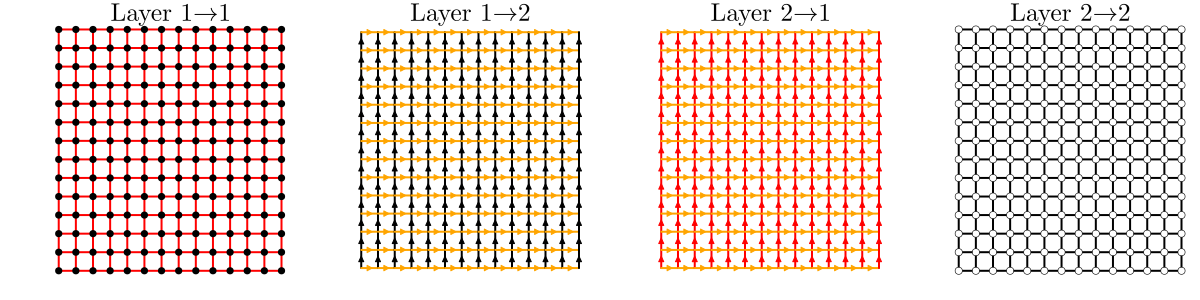

In [104]:
viz_enabled = true # show visualization of the Hamiltonian
if viz_enabled
    visualize(h,m,0)
end

### Symmetries

In this section, we construct operators implementing several symmetries of $h$ and verify that they are indeed symmetries.

#### Layer Swap

We construct a unitary that swaps a site in the first layer with the corresponding site in the second layer, and vice versa.

In [105]:
swap = zeros((2*L^2,2*L^2))
for i in 1:L
    for j in 1:L
        ind1 = idx(i,j,1); ind2 = idx(i,j,2);
        swap[ind1,ind2] = 1; swap[ind2,ind1] = 1;
    end
end

Let's check that $h$ has the SWAP symmetry $h_{\sigma\sigma'}=-h_{\sigma'\sigma}^*$, where $\sigma$, $\sigma'\in\{\uparrow,\downarrow\}$ denotes the layer.

In [106]:
println("|h-SWAP(-h^*)SWAP|: ",norm(h - swap*(conj.(-h))*swap'))

|h-SWAP(-h^*)SWAP|: 0.0


#### Translation

We define the one-site translation symmetries in the $x$- and $y$-directions, which are realized by $T_{\hat x}$ and $T_{\hat y}$.

In [107]:
Tx = zeros((2*L^2,2*L^2))
for i in 1:L
    for j in 1:L
        ind1 = idx(i,j,1)
        indpx1 = idx(mod1(i+1,L),j,1)
        ind2 = idx(i,j,2)
        indpx2 = idx(mod1(i+1,L),j,2)
        
        Tx[indpx1,ind1] = 1
        Tx[indpx2,ind2] = 1
    end
end

Ty = zeros((2*L^2,2*L^2))
for i in 1:L
    for j in 1:L
        ind1 = idx(i,j,1)
        indpx1 = idx(i,mod1(j+1,L),1)
        ind2 = idx(i,j,2)
        indpx2 = idx(i,mod1(j+1,L),2)
        
        Ty[indpx1,ind1] = 1
        Ty[indpx2,ind2] = 1
    end
end

Let's verify that $T_{\hat x}$ and $T_{\hat y}$ are unitary:

In [108]:
Tx_unitary = norm(Tx*Tx'-I)<1e-8
Ty_unitary = norm(Ty*Ty'-I)<1e-8

display(latexstring("T_{\\hat x}\\;\\mathrm{unitary}?:\\; \\mathrm{$Tx_unitary}"))
display(latexstring("T_{\\hat y}\\;\\mathrm{unitary}?:\\; \\mathrm{$Ty_unitary}"))

L"$T_{\hat x}\;\mathrm{unitary}?:\; \mathrm{true}$"

L"$T_{\hat y}\;\mathrm{unitary}?:\; \mathrm{true}$"

We now show that $h$ is symmetric under $T_{\hat x}$ and $T_{\hat y}$ by computing that the commutators $[h,T_{\hat x/\hat y}]$ vanish:

In [111]:
Tx_comm = norm(h*Tx-Tx*h)
Ty_comm = norm(h*Ty-Ty*h)

display(latexstring("|[h,T_{\\hat x}]|:\\;$Tx_comm"))
display(latexstring("|[h,T_{\\hat y}]|:\\;$Ty_comm"))

L"$|[h,T_{\hat x}]|:\;0.0$"

L"$|[h,T_{\hat y}]|:\;0.0$"

#### Rotation

There are inequivalent rotation symmetries $C_{4,A}$ and $C_{4,B}$, centered on plaquette centers and vertices, respectively. These symmetries act as
$$C_{4,o} c_{\vec\imath,\sigma} C_{4,o}^\dagger  = e^{i\lambda^{4,o}_{\vec\imath}}c_{R^o_{\pi/2}(\vec\imath),\sigma},$$
where $R^o_{\pi/2}(\vec\imath)$ is the coordinate obtained by rotating $\vec\imath$ by $\pi/2$ radians about the point $o$ and $e^{i\lambda^{4,o}_{\vec\imath}}$ is a site-dependent gauge transformation. We construct unitaries which implement these transformations on the first-quantized Hamiltonian:

In [120]:
## Plaquette-Centered Rotation ##
origin = [Int(L/2)+1/2,Int(L/2)+1/2]
rot_angle = pi/2

rows = []
cols = []
data = Vector{Complex{Float64}}()

for i in 1:L
    for j in 1:L
        for k in 1:2
            rot_point = rot(origin,[i,j],rot_angle)
            push!(rows, idx(rot_point[1],rot_point[2],k))
            push!(cols, idx(i,j,k))
            if (k==1)
                push!(data, im)
            else
                push!(data, 1)
            end
        end
    end  
end

C4_plaq = SparseArrays.sparse(rows, cols, data, 2*L^2, 2*L^2);

In [121]:
## Vertex-Centered Rotation ##
origin = [Int(L/2),Int(L/2)];

rows = []
cols = []
data = Vector{Complex{Float64}}()

for i in 1:L
    for j in 1:L
        for k in 1:2
            rot_point = rot(origin,[i,j],rot_angle)
            push!(rows, idx(mod1(rot_point[1],L),mod1(rot_point[2],L),k))
            push!(cols, idx(i,j,k))
            if (k==1)
                push!(data, im)
            else
                push!(data, 1)
            end
        end
    end  
end

C4_vert = SparseArrays.sparse(rows, cols, data, 2*L^2, 2*L^2);

Let's verify that $C_{4,A}$ and $C_{4,B}$ are unitary:

In [138]:
C4_plaq_unitary = norm(C4_plaq*C4_plaq'-I)<1e-8
C4_vert_unitary = norm(C4_vert*C4_vert'-I)<1e-8

display(latexstring("C_{4,A}\\;\\mathrm{unitary}?:\\; \\mathrm{$C4_plaq_unitary}"))
display(latexstring("C_{4,B}\\;\\mathrm{unitary}?:\\; \\mathrm{$C4_vert_unitary}"))

L"$C_{4,A}\;\mathrm{unitary}?:\; \mathrm{true}$"

L"$C_{4,B}\;\mathrm{unitary}?:\; \mathrm{true}$"

Let's show that $h$ has the $C_{4,A}$ and $C_{4,B}$ symmetries:

In [137]:
C4_plaq_comm = norm(h*C4_plaq-C4_plaq*h)
C4_vert_comm = norm(h*C4_vert-C4_vert*h)

display(latexstring("|[h,C_{4,A}]|:\\;$C4_plaq_comm"))
display(latexstring("|[h,C_{4,B}]|:\\;$C4_vert_comm"))

L"$|[h,C_{4,A}]|:\;0.0$"

L"$|[h,C_{4,B}]|:\;0.0$"

### Diagonalization

In this section, we diagonalize $h$ and plot its spectrum.

In [124]:
@time eigenvalues, eigenvectors = eigen(Matrix(h));

  0.086928 seconds (24 allocations: 9.691 MiB, 18.92% gc time)


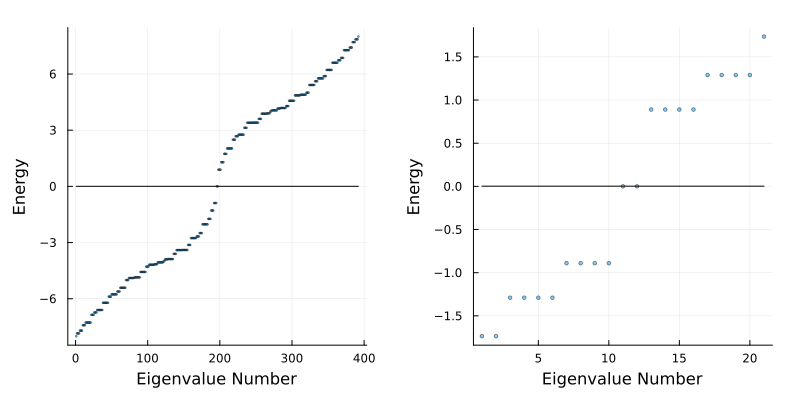

In [116]:
window = 10 # number of eigenvalues to zoom in on
mu = 0.002 # should be slightly greater than zero so all zero-energy eigenstates are included

plot1 = plot(eigenvalues,seriestype=:scatter, ms=1, ma=0.5,legend=false)
plot!(zeros(2*L^2) .+ mu, c=:black)
xlabel!("Eigenvalue Number")
ylabel!("Energy")

plot2 = plot(eigenvalues[Int(round(2*L^2/2))-window:1:Int(round(2*L^2/2))+window],seriestype=:scatter, ms=2, ma=0.5,legend=false)
plot!(zeros(2*window+1).+ mu, c=:black)
xlabel!("Eigenvalue Number")
ylabel!("Energy")

plot(plot1,plot2,layout=(1,2),size=(800,400),margin=5Plots.mm)

The many-body groundstate is the Slater determinant formed from all single-particle eigenstates with energy less than the chemical potential $\mu$.

In [117]:
filled_indices = findall(real(eigenvalues) .< mu);
filled_levels = eigenvectors[:,filled_indices];

### Symmetry Eigenvalues

In this section, we compute eigenvalues of the Dirac fermion under various spatial symmetry operations. We first have to find the degenerate zero-energy subspace.

In [125]:
zero_degen = length(findall(abs.(eigenvalues) .< 1e-5))
zero_eigs = eigenvectors[:,Int(round(2*L^2/2)-zero_degen/2+1):Int(round(2*L^2/2)+zero_degen/2)];

println("There are ",zero_degen," zero-energy eigenstates")

There are 2 zero-energy eigenstates


#### Rotations

We now construct the effective rotation operators in the zero-energy eigenspace:

In [126]:
C4_plaq_mat = zero_eigs'*C4_plaq*zero_eigs;
C4_vert_mat = zero_eigs'*C4_vert*zero_eigs;

Let's verify that they are still unitary matrices:

In [135]:
C4_plaq_zero_unitary = norm(C4_plaq_mat*C4_plaq_mat'-I)<1e-9
C4_vert_zero_unitary = norm(C4_vert_mat*C4_vert_mat'-I)<1e-9

display(latexstring("C_{4,A}|_{E=0}\\;\\mathrm{unitary}?:\\;\\mathrm{$C4_plaq_zero_unitary}"))
display(latexstring("C_{4,B}|_{E=0}\\;\\mathrm{unitary}?:\\;\\mathrm{$C4_vert_zero_unitary}"))

L"$C_{4,A}|_{E=0}\;\mathrm{unitary}?:\;\mathrm{true}$"

L"$C_{4,B}|_{E=0}\;\mathrm{unitary}?:\;\mathrm{true}$"

Diagonalizing the rotation symmetry action in the zero-energy eigenspace, we find the following eigenvalues:

In [306]:
U = eigvecs((C4_plaq_mat));
display(round.(diag(U'*C4_plaq_mat*U),digits=2))
U = eigvecs((C4_vert_mat));
display(round.(diag(U'*C4_vert_mat*U),digits=2))

4-element Vector{ComplexF64}:
 -1.0 - 0.0im
 -0.0 - 1.0im
  0.0 + 1.0im
  1.0 + 0.0im

4-element Vector{ComplexF64}:
 -1.0 - 0.0im
 -0.0 + 1.0im
  0.0 - 1.0im
  1.0 + 0.0im

We know that there exists a basis in which the Dirac fermion transforms under rotations as
$$C_{M,o}: \Psi_{\vec{k}_\star} \rightarrow e^{i\frac{2\pi}{M}s_o} \Lambda(2\pi/M)
     \Psi_{\vec{k}_\star}, $$
where $\Lambda(2\pi/M) = e^{i \frac{1}{2} \frac{2\pi}{M} \sigma^z}$. We can therefore read off the value of $s_o$ for each Dirac fermion from the eigenvalues we have calculated.

#### Translations

We now construct the effective translation operators in the zero-energy eigenspace:

In [140]:
Tx_mat = zero_eigs'*Tx*zero_eigs;
Ty_mat = zero_eigs'*Ty*zero_eigs;

Let's verify that they are still unitary matrices:

In [141]:
println("Tx unitary?: ",norm(Tx_mat - Tx_mat')<1e-9)
println("Ty unitary?: ",norm(Ty_mat - Ty_mat')<1e-9)

Tx unitary?: true
Ty unitary?: true


We will now diagonalize the rotation symmetry action in the zero-energy eigenspace. It is crucial that we choose the same basis tranformation for both symmetries because we want to be able to pair up $k_x$ with the corresponding $k_y$. We find the following eigenvalues:

In [142]:
U = eigvecs(Hermitian(Tx_mat));

display(round.(diag(U'*Tx_mat*U),digits=2))
display(round.(diag(U'*Ty_mat*U),digits=2))

2-element Vector{ComplexF64}:
 1.0 - 0.0im
 1.0 - 0.0im

2-element Vector{ComplexF64}:
 1.0 + 0.0im
 1.0 - 0.0im

We know that translations act on each Dirac fermion as
$$T_{\vec{v}}:\Psi_{k_\star}\rightarrow e^{i \vec{k}_\star\cdot \vec{v}}\Psi_{\vec{k}_\star}.$$
We can therefore read off the value of $\vec{k}_\star$ for each Dirac fermion from the eigenvalues we have calculated.

## Gapped Calculations

In this section, we will find the topological invariants in the gapped phases via partial rotations.

### Parameter Input

We have two model parameters:
- L: linear dimension of lattice
- m: strength of staggered on-site potential

In [346]:
## Model Parameters ##
L = 21       # odd
m = 2;       # strength of staggered on-site potential (must be between -4, 0, and 4)

We construct the first quantized Hamiltonian $h$, defined so that
$$H=\sum_{i,j}c^\dagger_i h_{ij} c_j,$$
on a lattice with open boundary conditions.

In [347]:
h = hamiltonian_obc(L,m,0);

As a consistency check, we verify that the Hamiltonian is Hermitian:

In [345]:
ishermitian(h)

true

Optionally, we can visualize the Hamiltonian:

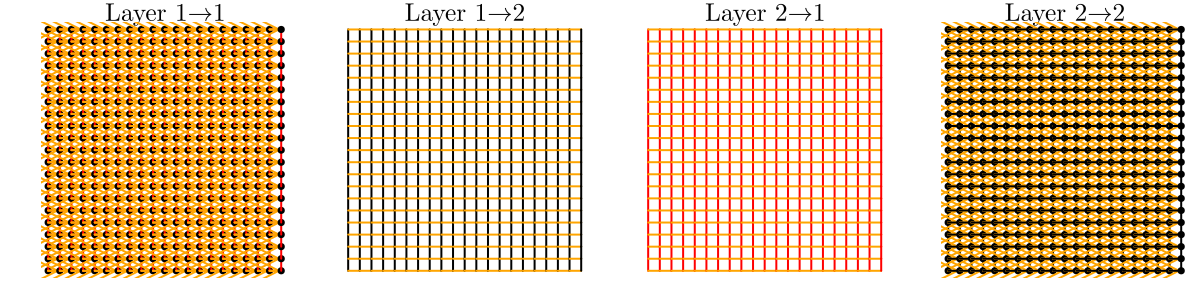

In [336]:
viz_enabled = true # show visualization of the Hamiltonian
if viz_enabled
    visualize(h,m,0)
end

### Symmetries

In this section, we construct operators implementing several symmetries of $h$ and verify that they are indeed symmetries.

#### Layer Swap

We construct a unitary that swaps a site in the first layer with the corresponding site in the second layer, and vice versa.

In [337]:
swap = zeros((2*L^2,2*L^2))
for i in 1:L
    for j in 1:L
        ind1 = idx(i,j,1); ind2 = idx(i,j,2);
        swap[ind1,ind2] = 1; swap[ind2,ind1] = 1;
    end
end

Let's check that $h$ has the SWAP symmetry $h_{\sigma\sigma'}=-h_{\sigma'\sigma}^*$, where $\sigma$, $\sigma'\in\{\uparrow,\downarrow\}$ denotes the layer.

In [338]:
println("|h-SWAP(-h^*)SWAP|: ",norm(h - swap*(conj.(-h))*swap'))

|h-SWAP(-h^*)SWAP|: 0.0


#### Translation

There is no exact translation symmetry for the lattice on open boundary conditions.

#### Rotation

On OBC with $L$ odd, we only have a single rotation center, which is a vertex.

We construct the unitary which implements this transformations on the first-quantized Hamiltonian:

In [349]:
origin = [L/2+1/2,L/2+1/2] 

rot_angle = pi/2

rows = []
cols = []
data = Vector{Complex{Float64}}()

for i in 1:L
    for j in 1:L
        for k in 1:2
            rot_point = rot(origin,[i,j],rot_angle)
            push!(rows, idx(rot_point[1],rot_point[2],k))
            push!(cols, idx(i,j,k))
            if (k==1)
                push!(data, im)
            else
                push!(data, 1)
            end
        end
    end  
end

C4 = SparseArrays.sparse(rows, cols, data, 2*L^2, 2*L^2);

Let's verify that $C_{4}$ is unitary:

In [350]:
println("C_4 unitary?: ",norm(C4*C4'-I)<1e-8)

C_4 unitary?: true


In [351]:
println("|[h,C_4]|: ",norm(h*C4-C4*h))

|[h,C_4]|: 0.0


### Diagonalization

In this section, we diagonalize $h$ and plot its spectrum. This time, we will see a gapped bulk spectrum, possibly with an edge mode if we are tuned to a phase with nonzero $C$.

In [354]:
@time eigenvalues, eigenvectors = eigen(Matrix(h));

  0.236438 seconds (20 allocations: 48.182 MiB)


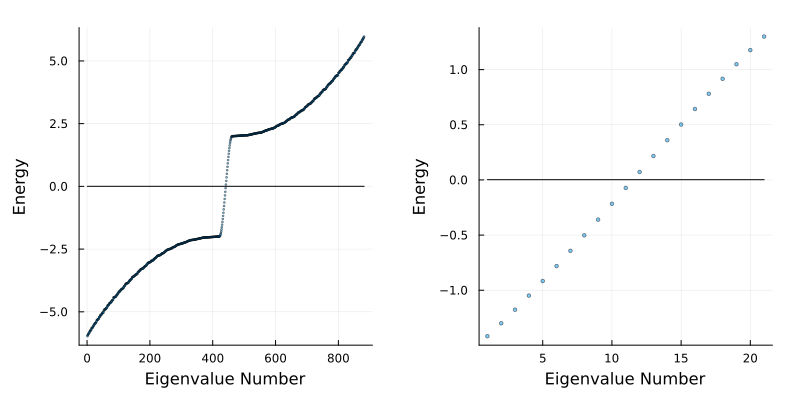

In [355]:
window = 10 # number of eigenvalues to zoom in on

plot1 = plot(eigenvalues,seriestype=:scatter, ms=1, ma=0.5,legend=false)
plot!(zeros(2*L^2) .+ mu, c=:black)
xlabel!("Eigenvalue Number")
ylabel!("Energy")

plot2 = plot(eigenvalues[Int(round(2*L^2/2))-window:1:Int(round(2*L^2/2))+window],seriestype=:scatter, ms=2, ma=0.5,legend=false)
plot!(zeros(2*window+1).+ mu, c=:black)
xlabel!("Eigenvalue Number")
ylabel!("Energy")

plot(plot1,plot2,layout=(1,2),size=(800,400),margin=5Plots.mm)

The many-body groundstate is the Slater determinant formed from all single-particle eigenstates with energy less than the chemical potential $\mu$.

In [356]:
mu = 0.002 # should be slightly greater than zero so all zero-energy eigenstates are included

filled_indices = findall(real(eigenvalues) .< mu);
filled_levels = eigenvectors[:,filled_indices];

### Partial Rotations

Throughout this section, we will reference definitions and formulae from in arXiv:2303.16919.

We will construct the two sets of operators $\tilde C_{4,\chi}^{+}$ and $\tilde C_{4,\chi}^{-}$. These are both symmetries of $h$, but one is order-four while the other is order-eight.

In [358]:
function C4_tilde_plus(L,R,χ)
    rows = []
    cols = []
    data = Vector{Complex{Float64}}()
    
    for i in 1:L
        for j in 1:L
            for k in 1:2
                if (i>=Int(L/2+1/2)-R)&&(i<=Int(L/2+1/2)+R)&&(j>=Int(L/2+1/2)-R)&&(j<=Int(L/2+1/2)+R)
                    rot_point = rot(origin,[i,j],rot_angle)
                    push!(rows, idx(rot_point[1],rot_point[2],k))
                    push!(cols, idx(i,j,k))
                    if (k==1)
                        push!(data, im*exp(im*χ*pi/2))
                    else
                        push!(data, 1*exp(im*χ*pi/2))
                    end
                else
                   push!(rows, idx(i,j,k)); push!(cols, idx(i,j,k)); push!(data,1);
                end
            end
        end  
    end
    
    M = SparseArrays.sparse(rows, cols, data, 2*L^2, 2*L^2)

    return M
end;

function C4_tilde_minus(L,R,χ)
    rows = []
    cols = []
    data = Vector{Complex{Float64}}()
    
    for i in 1:L
        for j in 1:L
            for k in 1:2
                if (i>=Int(L/2+1/2)-R)&&(i<=Int(L/2+1/2)+R)&&(j>=Int(L/2+1/2)-R)&&(j<=Int(L/2+1/2)+R)
                    rot_point = rot(origin,[i,j],rot_angle)
                    push!(rows, idx(rot_point[1],rot_point[2],k))
                    push!(cols, idx(i,j,k))
                    if (k==1)
                        push!(data, im*exp(im*χ*pi/2)*exp(im*pi/4))
                    else
                        push!(data, 1*exp(im*χ*pi/2)*exp(im*pi/4))
                    end
                else
                   push!(rows, idx(i,j,k)); push!(cols, idx(i,j,k)); push!(data,1);
                end
            end
        end  
    end
    
    M = SparseArrays.sparse(rows, cols, data, 2*L^2, 2*L^2)

    return M
end;

These operators should be symmetries which satisfy $(\tilde C_{4,\chi}^{+})=+I$ and $(\tilde C_{4,\chi}^{-})^4=(-1)^{F}$, which we verify:

In [377]:
M = C4_tilde_plus(L,L/2,0)
display(L"(C^+_4)^4=I?:")
println(norm(M*M*M*M - I)<1e-8)
display(L"[C^+_4,h]:")
println(norm(M*h-h*M))

M = C4_tilde_minus(L,L/2,0)
display(L"(C^-_4)^4=-I?:")
println(norm(M*M*M*M + I)<1e-8)
display(L"[C^-_4,h]:")
println(norm(M*h-h*M))

L"$(C^+_4)^4=I?:$"

true


L"$[C^+_4,h]:$"

0.0


L"$(C^-_4)^4=-I?:$"

true


L"$[C^-_4,h]:$"

0.0


We now want to restrict $C_{4,\chi}^\pm$ to a rotationally invariant set of sites $D$, which we denote $C_{4,\chi}^\pm|_D$. We want to choose the radius $R$ to be sufficiently large so that we capture the bulk behavior, without making it so large that the edge influences the result.

We can then extract universal information via the formula:
\begin{equation*}
   \bra{\Psi}C_{M,o,\chi}^{\pm}|_D\ket{\Psi}=e^{\frac{2\pi i}{M}l_{D,o,\chi}^{\pm}-\gamma_{D,o,\chi}^{\pm}},
\end{equation*}
where $\gamma_{D,o,\chi}^{\pm}\propto \partial D$ sets the real-valued amplitude and $l_{D,o,\chi}^{\pm}$ encodes the topological data. In particular, $l_{D,o,\chi}^{\pm}$ satisfies
\begin{equation}
    l_{D,o,\chi}^{\pm}= \frac{C \chi^2}{2} + \mathcal{S}_o^{\pm}\chi + K_o^{\pm}\text{ mod }M.
\end{equation}

In [387]:
χ_list = 0:3
C_tilde_plus_list = []
C_tilde_minus_list = []
l_plus_list = []
l_minus_list = []

R = 5

filled_indices = findall(real(eigenvalues) .< mu);
filled_levels = eigenvectors[:,filled_indices];

for χ in χ_list
    # Construct the rotation operator
    C_tilde_plus_chi_D = C4_tilde_plus(L,R,χ)
    C_tilde_minus_chi_D = C4_tilde_minus(L,R,χ)
    
    # Find expectation value
    expect_C_tilde_plus_chi_D = det(filled_levels' * C_tilde_plus_chi_D * filled_levels)
    expect_C_tilde_minus_chi_D = det(filled_levels' * C_tilde_minus_chi_D * filled_levels)
    
    l_plus = 2*angle(expect_C_tilde_plus_chi_D)/pi
    l_minus = 2*angle(expect_C_tilde_minus_chi_D)/pi
    
    push!(C_tilde_plus_list,expect_C_tilde_plus_chi_D)
    push!(C_tilde_minus_list,expect_C_tilde_minus_chi_D)
    push!(l_plus_list,l_plus)
    push!(l_minus_list,l_minus)
end

In [408]:
Theta_plus = mod(l_plus_list[1],2)
Theta_minus = mod(l_minus_list[1],4)
S = mod((2*(Theta_minus-Theta_plus)),4)

display(latexstring("\\Theta^+:\\;$Theta_plus"))
display(latexstring("\\Theta^-:\\;$Theta_minus"))
display(latexstring("\\mathcal{S}:\\;$S"))

L"$\Theta^+:\;0.5001304215610944$"

L"$\Theta^-:\;1.2500501888609246$"

L"$\mathcal{S}:\;1.4998395345996602$"

$\Theta^+$ should be a multiple of $\frac{1}{2}$, and $\Theta^-$ should be a multiple of $\frac{1}{4}$.

#### Fitting to the $l$ vs $\chi$ curve

Let's fit a quadratic polynomial mod 4 to the $\langle \Psi|\tilde C^+_{4,\chi}|\Psi\rangle$ vs. $\chi$ data. We tune by hand $C$, $\mathcal{S}^+$, and $K^+$ to fit the data.

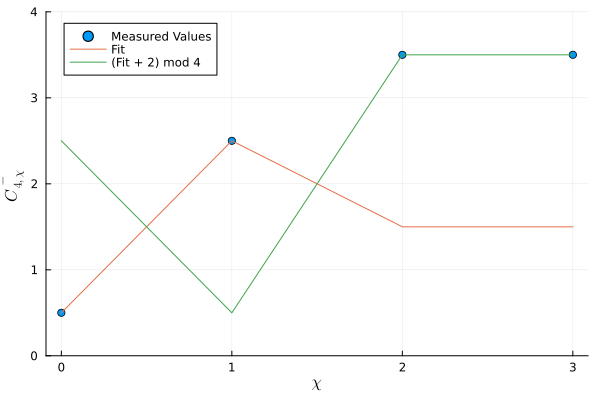

In [405]:
## These parameters should be tuned by hand to interpolate the data
C = 1
S_plus = S 
K_plus = 0.5

scatter(χ_list,mod.(l_plus_list,4),ylims=(0,4),label="Measured Values")
plot!(χ_list,mod.((C/2)*(χ_list.^2) .+ S_plus*χ_list .+ K_plus,4),label="Fit")
plot!(χ_list,mod.((C/2)*(χ_list.^2) .+ S_plus*χ_list .+ K_plus .+ 2,4),label="(Fit + 2) mod 4")

xlabel!(L"\chi")
ylabel!(L"C_{4,\chi}^-")

Now, let's fit a quadratic polynomial mod 4 to the $\langle \Psi|\tilde C^-_{4,\chi}|\Psi\rangle$ vs. $\chi$ data:

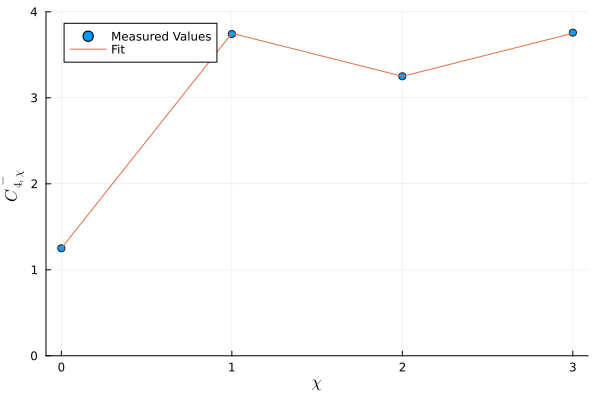

In [401]:
S_minus = 2
K_minus = 1.25

scatter(χ_list,mod.(l_minus_list,4),ylims=(0,4),label="Measured Values")
plot!(χ_list,mod.((C/2)*χ_list.^2+S_minus*χ_list.+K_minus,4),label="Fit")
xlabel!(L"\chi")
ylabel!(L"C_{4,\chi}^-")

Now that we have $K^+$ and $K^-$, we can find $\Theta^+:=K^+ \text{ mod }2$ and $\Theta^-:=K^- \text{ mod }4$ and use 
$$2(\Theta^--\Theta^+)=\mathcal{S}^+\text{ mod }4$$
to extract the discrete shift $\mathcal{S}$ and the $M=4$ relation
$$\ell=\frac{5}{4}C+2\Theta_o^+\text{ mod }4,\text{ }$$
to extract $\ell$.

In [397]:
Theta_plus = mod(K_plus,2)
Theta_minus = mod(K_minus,4)
S = mod((2*(Theta_minus-Theta_plus)),4)

l = mod((5/4)*C + 2*Theta_plus,4)

display(latexstring("C:\\;$C\\qquad \\mathcal{S}:\\;$S\\qquad \\ell:\\;$l\\qquad \\Theta^+:\\;$Theta_plus\\qquad\\Theta^-:\\;$Theta_minus"))

L"$C:\;1\qquad \mathcal{S}:\;1.5\qquad \ell:\;2.25\qquad \Theta^+:\;0.5\qquad\Theta^-:\;1.25$"

# Defect Hamiltonians

In this section, we present the code for measuring the current and energy density in the QWZ model on a lattice with various crystalline defects.

## Disclinations

### Parameter Input

In [49]:
## Model Parameters ##
n = 7 # tunes the size of the lattice
m = 4 # -4 or 4
mu = 0.002;
disc_type = "vertex"; # "plaquette" or "vertex"

In [50]:
## Defining Variables ##
L = 2*n+1

if disc_type == "vertex"
    Lx = Int(L/2-1/2)
    Ly = Int(L/2+1/2)

    L_tot = 2*(3*Int(L/2+1/2)*Int(L/2-1/2)+1)

    o1 = 2*(3*Ly*Lx+1)-1
    o2 = 2*(3*Ly*Lx+1)
    origin = [Lx,Lx];

elseif disc_type == "plaquette"
    Lx = Int(L/2+1/2)
    Ly = Int(L/2+1/2)
    L_tot = 2*(3*Lx^2)

    origin = [0,0]
end

rot_angle = pi/2;

In [51]:
if disc_type == "vertex"
    H_disc = vert_disc_hamiltonian(L,m,pi/4);
elseif disc_type == "plaquette"
    H_disc = plaq_disc_hamiltonian(L,m,pi/4);
end;

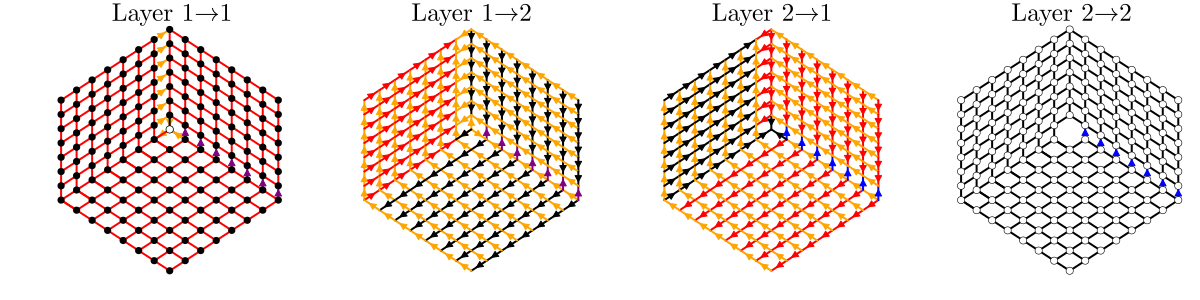

In [52]:
viz_enabled = true;
if viz_enabled
    disc_visualize(H_disc,m,pi/4)
end

### Generating Data

Here, we calculate the current and energy density in a wedge of the lattice with disclination.

In [29]:
## Iterating over flux inserted at disclination core ##
big_data = []; H_list = [];
δϕs = 0:0.2:2*pi
@showprogress for δϕ in δϕs
    ## Create and diagonalize Hamiltonian ##
    if disc_type == "vertex"
        H_disc = vert_disc_hamiltonian(L,m,δϕ);
    elseif disc_type == "plaquette"
        H_disc = plaq_disc_hamiltonian(L,m,δϕ);
    end
    
    eigenvalues_disc, eigenvectors_disc = eigen(Matrix(H_disc));

    filled_indices = findall(real(eigenvalues_disc) .< mu);
    filled_levels = eigenvectors_disc[:,filled_indices];

    ## Compute current density ##
    A_x_plus = Vector{Vector{ComplexF64}}()
    B_x_plus = Vector{Vector{ComplexF64}}()
    A_x_minus = Vector{Vector{ComplexF64}}()
    B_x_minus = Vector{Vector{ComplexF64}}()

    A_y_plus = Vector{Vector{ComplexF64}}()
    B_y_plus = Vector{Vector{ComplexF64}}()
    A_y_minus = Vector{Vector{ComplexF64}}()
    B_y_minus = Vector{Vector{ComplexF64}}()

    global x_distances = []
    global y_distances = []

    cos_θ = []
    sin_θ = []

    i_list = []
    j_list = []
    
    global uc_indices = []

    for i in 1:1:Lx-1
        for j in 1:1:Ly-1
            push!(A_x_plus,filled_levels[disc_idx(i+1,j+1,1,1),:])
            push!(B_x_plus,filled_levels[disc_idx(i+1,j+1,2,1),:])
            push!(A_x_minus,filled_levels[disc_idx(i,j+1,1,1),:])
            push!(B_x_minus,filled_levels[disc_idx(i,j+1,2,1),:])

            push!(A_y_plus,filled_levels[disc_idx(i+1,j+1,1,1),:])
            push!(B_y_plus,filled_levels[disc_idx(i+1,j+1,2,1),:])
            push!(A_y_minus,filled_levels[disc_idx(i+1,j,1,1),:])
            push!(B_y_minus,filled_levels[disc_idx(i+1,j,2,1),:])

            if disc_type == "vertex"
                x = -Lx+i-1; y = j-1;
            elseif disc_type == "plaquette"
                x = -Lx+i-1/2; y = j-1/2;
            end

            push!(x_distances,x)
            push!(y_distances,y)

            push!(cos_θ,x/sqrt(x^2+y^2))
            push!(sin_θ,y/sqrt(x^2+y^2))

            push!(i_list,i)
            push!(j_list,j)
            
            push!(uc_indices,disc_idx(i+1,j+1,1,1))
        end
    end

    A_x_plus = reduce(hcat,A_x_plus);
    B_x_plus = reduce(hcat,B_x_plus);
    A_x_minus = reduce(hcat,A_x_minus);
    B_x_minus = reduce(hcat,B_x_minus);

    A_y_plus = reduce(hcat,A_y_plus);
    B_y_plus = reduce(hcat,B_y_plus);
    A_y_minus = reduce(hcat,A_y_minus);
    B_y_minus = reduce(hcat,B_y_minus);

    xpmAA = sum(A_x_plus .* conj(A_x_minus),dims=1);
    xpmAB = sum(A_x_plus .* conj(B_x_minus),dims=1);
    xpmBA = sum(B_x_plus .* conj(A_x_minus),dims=1);
    xpmBB = sum(B_x_plus .* conj(B_x_minus),dims=1);

    ypmAA = sum(A_y_plus .* conj(A_y_minus),dims=1);
    ypmAB = sum(A_y_plus .* conj(B_y_minus),dims=1);
    ypmBA = sum(B_y_plus .* conj(A_y_minus),dims=1);
    ypmBB = sum(B_y_plus .* conj(B_y_minus),dims=1);

    xmpAA = sum(A_x_minus .* conj(A_x_plus),dims=1);
    xmpAB = sum(A_x_minus .* conj(B_x_plus),dims=1);
    xmpBA = sum(B_x_minus .* conj(A_x_plus),dims=1);
    xmpBB = sum(B_x_minus .* conj(B_x_plus),dims=1);

    ympAA = sum(A_y_minus .* conj(A_y_plus),dims=1);
    ympAB = sum(A_y_minus .* conj(B_y_plus),dims=1);
    ympBA = sum(B_y_minus .* conj(A_y_plus),dims=1);
    ympBB = sum(B_y_minus .* conj(B_y_plus),dims=1);

    Jx = -im*(-xpmAA+im*xpmBA+xmpAA+im*xmpAB+xpmBB+im*xpmAB-xmpBB+im*xmpBA);
    Jy = im*(ypmBA-ypmAA-ypmAB+ypmBB-ympAB+ympAA+ympBA-ympBB);

    global jθ_micro = -y_distances'.*Jx+x_distances'.*Jy;
    
    ## Optionally, construct a plot of the current density
    xs = []
    ys = []
    vals = []
    for ind in 1:length(i_list)
        i = i_list[ind]
        j = j_list[ind]
        x, y = idx_to_2d(disc_idx(i,j,1,1))
        val = real(jθ_micro)[ind]
        push!(xs,x)
        push!(ys,y)
        push!(vals,val)
    end

    s = scatter(xs, ys, zcolor=vals, marker=:circle, clim=(-0.01,0.01), cmap=cgrad([:black,:red,:yellow,:white]), markersize=7,legend=true,size=((500,500)),markerstrokewidth=0,label=false,margin=5Plots.mm)
    # display(s) ## Uncomment to print plots
    
    push!(big_data,real(jθ_micro));

    ## Compute energy density ##
    local_H = diag(filled_levels*filled_levels'*H_disc);
    
    up_indices = []; down_indices = [];
    H_i_list = []; H_j_list = [];
    for i in 1:Lx
        for j in 1:Ly
            push!(up_indices,disc_idx(i,j,1,1))
            push!(down_indices,disc_idx(i,j,2,1))

            push!(H_i_list,i); push!(H_j_list,j);
        end
    end
    
    global local_H_sum = local_H[up_indices] .+ local_H[down_indices];
        
    push!(H_list,local_H_sum)

    xs = []; ys = []; vals = [];
    global H_x_distances = []; global H_y_distances = [];
    for ind in 1:length(local_H_sum)
        i = H_i_list[ind]; j = H_j_list[ind];
        if disc_type == "vertex"
            x = -Lx+i-1; y = j-1;
        elseif disc_type == "plaquette"
            x = -Lx+i-1/2; y = j-1/2;
        end
        push!(xs,x)
        push!(ys,y)
        push!(vals,real(local_H_sum[ind]))
        push!(H_x_distances,x); push!(H_y_distances,y);
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [30]:
data_tensor = (vcat(big_data...))';
H_data_tensor = real.((hcat(H_list...)));

### Choosing sites to plot

In this section, we extract indices which are in the bulk of the lattice, neither too close to the defect core nor the edge, to include in our final plot.

In [33]:
## PARAMETERS ##
x_min_scale = 0.1; x_max_scale = 0.4; # in [0,0.5]
y_min_scale = 0.1; y_max_scale = 0.4; # in [0,0.5]
################

if (x_min_scale >= x_max_scale)|(y_min_scale >= y_max_scale)
    error("ERROR: Invalid bounds")
end

meas_indices = []
for i in 1:length(jθ_micro)
    x = x_distances[i]
    y = y_distances[i]
        
    x_max = maximum(x_distances); x_min = minimum(x_distances); x_range = x_max - x_min;
    y_max = maximum(y_distances); y_min = minimum(y_distances); y_range = y_max - y_min;    
    
    if (x>x_min+x_range/2+x_min_scale*x_range)&&(x<x_min+x_range/2+x_max_scale*x_range)&&(y>y_min+y_range/2-y_max_scale*y_range)&&(y<y_min+y_range/2-y_min_scale*y_range)
        push!(meas_indices,i)
    end
end

H_meas_indices = []
for i in 1:length(local_H_sum)
    x = H_x_distances[i]
    y = H_y_distances[i]
        
    x_max = maximum(H_x_distances); x_min = minimum(H_x_distances); x_range = x_max - x_min;
    y_max = maximum(H_y_distances); y_min = minimum(H_y_distances); y_range = y_max - y_min;    
    
    if (x>x_min+x_range/2+x_min_scale*x_range)&&(x<x_min+x_range/2+x_max_scale*x_range)&&(y>y_min+y_range/2-y_max_scale*y_range)&&(y<y_min+y_range/2-y_min_scale*y_range)
        push!(H_meas_indices,i)
    end
end

if (length(meas_indices)== 0)|(length(H_meas_indices) == 0) 
    error("ERROR: No sites in specified range. Increase system size or range cutoff.")
else 
    n_sites = length(meas_indices)
    println("There are $n_sites sites in the specified range")
end

There are 4 sites in the specified range


### Finding zeros and extrema

We now find the zero crossings of the current and the minima and maxima of the energy density as a function of applied flux $\delta\alpha$. 

In [34]:
x_intercept_list = []

flip = 1
for ind in meas_indices
    xs = δϕs
    ys = data_tensor[ind,:]

    old_sign = ys[end]/abs(ys[end])
    for i in 1:length(ys)
        new_sign = ys[i]/abs(ys[i])
        if old_sign < 0 && new_sign > 0
            global flip = i
        end
        old_sign = copy(new_sign)
    end

    q = (ys[flip]-ys[mod1(flip-1,length(ys))])/(xs[flip]-xs[mod1(flip-1,length(ys))])
    b = ys[mod1(flip-1,length(ys))]

    Δx = -ys[mod1(flip-1,length(ys))]/q

    x_intercept = xs[mod1(flip-1,length(ys))]+Δx
    
    push!(x_intercept_list,x_intercept)
end

In [35]:
other_x_intercept_list = []

for ind in meas_indices
    xs = δϕs
    ys = data_tensor[ind,:]

    old_sign = ys[end]/abs(ys[end])
    for i in 1:length(ys)
        new_sign = ys[i]/abs(ys[i])
        if old_sign > 0 && new_sign < 0
            global flip = i
        end
        old_sign = copy(new_sign)
    end

    q = (ys[flip]-ys[mod1(flip-1,length(ys))])/(xs[flip]-xs[mod1(flip-1,length(ys))])
    b = ys[mod1(flip-1,length(ys))]

    Δx = -ys[mod1(flip-1,length(ys))]/q

    x_intercept = xs[mod1(flip-1,length(ys))]+Δx
    
    push!(other_x_intercept_list,x_intercept)
end

In [36]:
max_list = []
for i in H_meas_indices
    peak = argmax(H_data_tensor[i,:])
    xs = collect(δϕs)[peak-2:peak+2]; ys = H_data_tensor[i,peak-2:peak+2];
    
    model(x, p) = p[1]*(x).^2 .+ p[2]*(x) .+ p[3]
    p0 = ones(3)

    fit = curve_fit(model, xs, ys, p0)
    fitted_params = fit.param
    
    xfit = range(minimum(xs), maximum(xs), length=1000) 
    yfit = model(xfit, fitted_params) 

    # Plot the data and the fit
    s = scatter(xs, ys, label="Data", color=:blue, legend=:topleft)
    plot!(xfit, yfit, label="Fit", color=:red, linewidth=2)
    
    push!(max_list,xfit[argmax(yfit)])

    # display(s) ## Uncomment to see the fit
end

In [37]:
min_list = []
for i in H_meas_indices
    peak = argmin(H_data_tensor[i,:])
    xs = collect(δϕs)[peak-2:peak+2]; ys = H_data_tensor[i,peak-2:peak+2];
    
    model(x, p) = p[1]*(x).^2 .+ p[2]*(x) .+ p[3]
    p0 = ones(3)

    fit = curve_fit(model, xs, ys, p0)
    fitted_params = fit.param
    
    xfit = range(minimum(xs), maximum(xs), length=1000)  # Smooth x range
    yfit = model(xfit, fitted_params)  # Corresponding y values

    # Plot the data and the fit
    s = scatter(xs, ys, label="Data", color=:blue, legend=:topleft)
    plot!(xfit, yfit, label="Fit", color=:red, linewidth=2)
    
    push!(min_list,xfit[argmin(yfit)])

    # display(s) ## Uncomment to see the fit
end

### Plotting

When we calculate the energy density, it comes with an arbitrary additive constant. In the following cell, we determine the true zero point of the energy density by finding where the energy density curves coalesce.

In [38]:
δϕs_refined = 0.1:0.01:2*pi-0.1
H_data_tensor_refined = zeros((length(H_meas_indices),length(δϕs_refined)))

for i in 1:length(H_meas_indices)
    H_data_tensor_refined[i,:] = [interpolate_y(δϕs, H_data_tensor[H_meas_indices[i],:], x_new) for x_new in δϕs_refined]
end
    
coal_ind = argmin(vec(maximum(H_data_tensor_refined,dims=1).-minimum(H_data_tensor_refined,dims=1)))

y_shift = mean(H_data_tensor_refined[:,coal_ind]);

We now combine everything to create the plot seen in the manuscript.

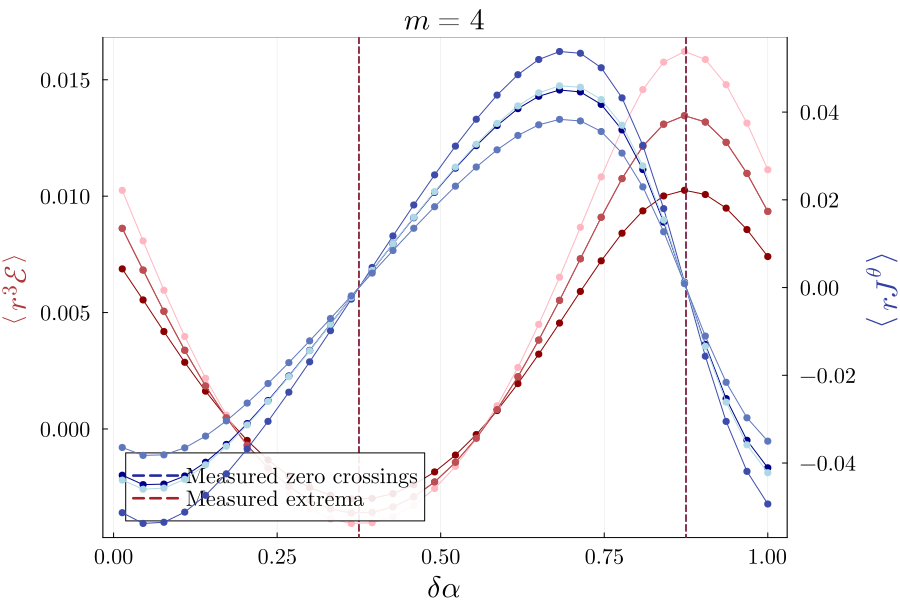

In [39]:
p = plot(size=(900,600),xtickfont=font("Computer Modern", 14), ytickfont=font("Computer Modern", 14), legendfont=font("Computer Modern", 14), guidefont=font("Computer Modern",20), titlefont=font("Computer Modern",20), background_color_legend=RGBA(1,1,1,0.9), legend=:bottomleft)

title!(latexstring("m = $m"))

x_origin = 0
y_origin = 0

x_meas_s = [H_x_distances[i] for i in H_meas_indices]
y_meas_s = [H_y_distances[i] for i in H_meas_indices]

distances = sqrt.((x_meas_s.-x_origin).^2 .+ ((y_meas_s.-y_origin).^2)')

min_dist = minimum(distances)
max_dist = maximum(distances)

ylabel!(p,L"\left\langle r^3\mathcal{E} \right\rangle")
xlabel!(p,L"\delta\alpha")

max_value = -1e5; min_value = 1e5;

δϕs = [i for i in 0:0.2:2*pi]

for i in H_meas_indices
    x_meas = H_x_distances[i]; y_meas = H_y_distances[i]; 
    distance = sqrt((x_meas-x_origin)^2+(y_meas-y_origin)^2)

    my_color = cgrad(:reds)[(distance-min_dist)/(max_dist-min_dist)]
    plot!(mod.(-δϕs./(2*pi).-1e-9,1),(distance^3).*(H_data_tensor[i,:].-y_shift),label=false,color=my_color,xtickfont=font("Computer Modern", 14), ytickfont=font("Computer Modern", 14), alpha=1.0, yformatter=:plain,yguidefontcolor=cgrad(:reds)[0.7],framestyle=:box)
    scatter!(mod.(-δϕs./(2*pi).-1e-9,1),(distance^3).*(H_data_tensor[i,:].-y_shift),label=false,zcolor=distance,markerstrokewidth=0.0,colormap=:reds, markersize=4,colorbar=false,alpha=1.0)
end

p_twin = twinx(p)

x_origin = 0
y_origin = 0

x_meas_s = [x_distances[i] for i in meas_indices]
y_meas_s = [y_distances[i] for i in meas_indices]

distances = sqrt.((x_meas_s.-x_origin).^2 .+ ((y_meas_s.-y_origin).^2)')

min_dist = minimum(distances)
max_dist = maximum(distances)

ylabel!(p_twin,L"\left\langle rJ^\theta \right\rangle")
xlabel!(p_twin,"")

max_value = -1e5; min_value = 1e5;
for i in meas_indices
    x_meas = x_distances[i]; y_meas = y_distances[i]; 
    distance = sqrt((x_meas-x_origin)^2+(y_meas-y_origin)^2)
    my_color = cgrad(:blues)[(distance-min_dist)/(max_dist-min_dist)]
    plot!(p_twin,mod.(-δϕs./(2*pi).-1e-9,1),-(distance^1).*(data_tensor[i,:]),label=false,color=my_color,legend=false, alpha=1.0, xtickfont=font("Computer Modern", 14), ytickfont=font("Computer Modern", 14), yformatter=:plain, yguidefontcolor=cgrad(:blues)[0.7],guidefont=font("Computer Modern",20))
    scatter!(p_twin,mod.(-δϕs./(2*pi).-1e-9,1),-(distance^1).*(data_tensor[i,:]),label=false,zcolor=distance,markerstrokewidth=0.0,colormap=:blues, markersize=4,colorbar=false, alpha=1.0, xtickfont=font("Computer Modern", 14), ytickfont=font("Computer Modern", 14), yformatter=:plain)
    
    rJθ = -(distance^1).*(data_tensor[i,:]); push!(rJθ,max_value); max_value = maximum(rJθ);
    rJθ = -(distance^1).*(data_tensor[i,:]); push!(rJθ,min_value); min_value = minimum(rJθ);
end

spread = max_value - min_value

## Negative to Positive ##
vline!([1-mean(x_intercept_list)/(2*pi)], linestyle=:dash, color=cgrad(:blues)[0.8], label="Measured zero crossings", lw=1.5)
vline!([1-mean(min_list)/(2*pi)], linestyle=:dash, color=cgrad(:reds)[0.8], label="Measured extrema", lw=1.5)

## Positive to Negative ##
vline!([1-mean(other_x_intercept_list)/(2*pi)], linestyle=:dash, color=cgrad(:blues)[0.8], label=false, lw=1.5)
vline!([1-mean(max_list)/(2*pi)], linestyle=:dash, color=cgrad(:reds)[0.8], label=false, lw=1.5)

plot!(p,left_margin = 2Plots.mm,right_margin = 3Plots.mm)

plot!(p,framestyle=:semi)

display(p)

## Dislocation

### Parameter Input

In [87]:
## PARAMETERS ##
n = 3; # tunes the size of the lattice
L = 4*n; 
m = -4; # -4 or 4
mu = 0.002;
################

In [88]:
## Defining variables
row_lengths = vcat([L for _ in 1:(L/2)],[L+1 for _ in 1:(L/2)])
L_tot = 2*sum(row_lengths)
origin = [0,0]

rot_angle = pi/2;
origin = [0,0];

H_disloc = disloc_hamiltonian(L, m, pi/4);

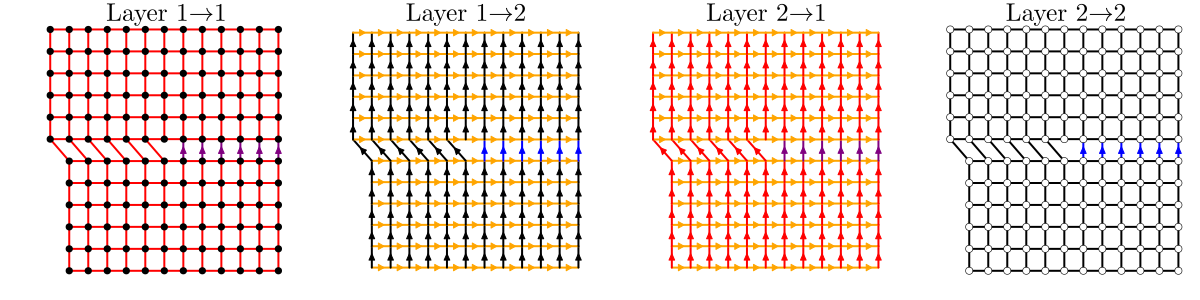

In [95]:
viz_enabled = true;
if viz_enabled
    disloc_visualize(H_disloc,m,pi/4)
end

### Generating Data

Here, we calculate the current and energy density in a lattice with a dislocation.

In [69]:
data_list = []; H_list = [];
δϕs = 0:0.2:2*pi
@showprogress for δϕ in δϕs
    ## Create and diagonalize Hamiltonian ##
    H = disloc_hamiltonian(L, m, δϕ);

    eigenvalues, eigenvectors = eigen(Matrix(H));

    filled_indices = findall(real(eigenvalues) .< mu);
    filled_levels = eigenvectors[:,filled_indices];

    ## Compute current density ##
    A_x_plus = Vector{Vector{ComplexF64}}()
    B_x_plus = Vector{Vector{ComplexF64}}()
    A_x_minus = Vector{Vector{ComplexF64}}()
    B_x_minus = Vector{Vector{ComplexF64}}()

    A_y_plus = Vector{Vector{ComplexF64}}()
    B_y_plus = Vector{Vector{ComplexF64}}()
    A_y_minus = Vector{Vector{ComplexF64}}()
    B_y_minus = Vector{Vector{ComplexF64}}()

    global x_distances = []
    global y_distances = []

    cos_θ = []
    sin_θ = []

    global i_list = []
    global j_list = []

    for j in Int(length(row_lengths)/2):length(row_lengths)-1
        len = row_lengths[j]
        for i in 1:len-1
            push!(A_x_plus,filled_levels[disloc_idx(i+1,j+1,1),:])
            push!(B_x_plus,filled_levels[disloc_idx(i+1,j+1,2),:])
            push!(A_x_minus,filled_levels[disloc_idx(i,j+1,1),:])
            push!(B_x_minus,filled_levels[disloc_idx(i,j+1,2),:])

            push!(A_y_plus,filled_levels[disloc_idx(i+1,j+1,1),:])
            push!(B_y_plus,filled_levels[disloc_idx(i+1,j+1,2),:])
            push!(A_y_minus,filled_levels[disloc_idx(i+1,j,1),:])
            push!(B_y_minus,filled_levels[disloc_idx(i+1,j,2),:])

            x = i-L/2
            y = j-length(row_lengths)/2

            push!(x_distances,x)
            push!(y_distances,y)

            push!(cos_θ,x/sqrt(x^2+y^2))
            push!(sin_θ,y/sqrt(x^2+y^2))

            push!(i_list,i)
            push!(j_list,j)
        end
    end

    A_x_plus = reduce(hcat,A_x_plus);
    B_x_plus = reduce(hcat,B_x_plus);
    A_x_minus = reduce(hcat,A_x_minus);
    B_x_minus = reduce(hcat,B_x_minus);

    A_y_plus = reduce(hcat,A_y_plus);
    B_y_plus = reduce(hcat,B_y_plus);
    A_y_minus = reduce(hcat,A_y_minus);
    B_y_minus = reduce(hcat,B_y_minus);

    xpmAA = sum(A_x_plus .* conj(A_x_minus),dims=1);
    xpmAB = sum(A_x_plus .* conj(B_x_minus),dims=1);
    xpmBA = sum(B_x_plus .* conj(A_x_minus),dims=1);
    xpmBB = sum(B_x_plus .* conj(B_x_minus),dims=1);

    ypmAA = sum(A_y_plus .* conj(A_y_minus),dims=1);
    ypmAB = sum(A_y_plus .* conj(B_y_minus),dims=1);
    ypmBA = sum(B_y_plus .* conj(A_y_minus),dims=1);
    ypmBB = sum(B_y_plus .* conj(B_y_minus),dims=1);

    xmpAA = sum(A_x_minus .* conj(A_x_plus),dims=1);
    xmpAB = sum(A_x_minus .* conj(B_x_plus),dims=1);
    xmpBA = sum(B_x_minus .* conj(A_x_plus),dims=1);
    xmpBB = sum(B_x_minus .* conj(B_x_plus),dims=1);

    ympAA = sum(A_y_minus .* conj(A_y_plus),dims=1);
    ympAB = sum(A_y_minus .* conj(B_y_plus),dims=1);
    ympBA = sum(B_y_minus .* conj(A_y_plus),dims=1);
    ympBB = sum(B_y_minus .* conj(B_y_plus),dims=1);

    Jx = -im*(-xpmAA+im*xpmBA+im*xpmAB+xpmBB+xmpAA+im*xmpAB-xmpBB+im*xmpBA);
    Jy = im*(ypmBA-ypmAA-ypmAB+ypmBB-ympAB+ympAA+ympBA-ympBB);

    global jθ_micro = -y_distances'.*Jx + x_distances'.*Jy;
    
    push!(data_list,jθ_micro)

    ## Optionally, construct a plot of the current density
    xs = []
    ys = []
    vals = []
    for i in 1:length(i_list)
        x = x_distances[i]
        y = y_distances[i]
        val = real(jθ_micro)[i]
        push!(xs,x)
        push!(ys,y)
        push!(vals,val)
    end

    ## Compute energy density ##
    local_H = diag(filled_levels*filled_levels'*H);
    global local_H_sum = local_H[1:2:end] + local_H[2:2:end];
    
    push!(H_list,local_H_sum)

    xs = []; ys = []; vals = [];
    global H_x_distances = []; global H_y_distances = [];
    for ind in 1:length(local_H)
        i, j, k = disloc_idx_inv(ind)
        if k == 2
            push!(xs,i)
            push!(ys,j)
            push!(vals,real(local_H_sum[Int(ind/2)]))
            push!(H_x_distances,i); push!(H_y_distances,j);
        end
    end

    s = scatter(xs, ys, zcolor=(vals), marker=:circle, cmap=cgrad([:black,:red,:yellow,:white]), markersize=4, clims = (-4.58,-4.565),legend=true,size=((500,500)),markerstrokewidth=0,label=false,margin=5Plots.mm)
    # display(s) ## Uncomment to print plots
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


In [81]:
data_tensor = real.((vcat(data_list...))');
H_data_tensor = real.((hcat(H_list...)));

### Choosing sites to plot

In this section, we extract indices which are in the bulk of the lattice, neither too close to the defect core nor the edge, to include in our final plot.

In [71]:
## PARAMETERS ##
x_min_scale = 0.05; x_max_scale = 0.15; # in [0,0.5]
y_min_scale = 0.1; y_max_scale = 0.2; # in [0,0.5]
################

if (x_min_scale >= x_max_scale)|(y_min_scale >= y_max_scale)
    error("ERROR: Invalid bounds")
end

meas_indices = []
for i in 1:length(jθ_micro)
    x = x_distances[i]
    y = y_distances[i]
        
    x_max = maximum(x_distances); x_min = minimum(x_distances); x_range = x_max - x_min;
    y_max = maximum(y_distances); y_min = minimum(y_distances); y_range = y_max - y_min;    
    
    if (x>x_min+x_range/2+x_min_scale*x_range)&&(x<x_min+x_range/2+x_max_scale*x_range)&&(y>y_min+y_range/2-y_max_scale*y_range)&&(y<y_min+y_range/2-y_min_scale*y_range)
        push!(meas_indices,i)
    end
end

H_meas_indices = []
for i in 1:length(local_H_sum)
    x = H_x_distances[i]
    y = H_y_distances[i]
        
    x_max = maximum(H_x_distances); x_min = minimum(H_x_distances); x_range = x_max - x_min;
    y_max = maximum(H_y_distances); y_min = minimum(H_y_distances); y_range = y_max - y_min;    
    
    if (x>x_min+x_range/2+x_min_scale*x_range)&&(x<x_min+x_range/2+x_max_scale*x_range)&&(y>y_min+y_range/2+y_min_scale*y_range)&&(y<y_min+y_range/2+y_max_scale*y_range)
        push!(H_meas_indices,i)
    end
end

if (length(meas_indices)== 0)|(length(H_meas_indices) == 0) 
    error("ERROR: No sites in specified range. Increase system size or range cutoff.")
else 
    n_sites = length(meas_indices)
    println("There are $n_sites sites in the specified range")
end

There are 3 sites in the specified range


### Finding zeros and extrema

We now find the zero crossings of the current and the minima and maxima of the energy density as a function of applied flux $\delta\alpha$. 

In [72]:
x_intercept_list = []

for ind in meas_indices
    xs = δϕs
    ys = data_tensor[ind,:]

    old_sign = ys[end]/abs(ys[end])
    for i in 1:length(ys)
        new_sign = ys[i]/abs(ys[i])
        if old_sign < 0 && new_sign > 0
            global flip = i
        end
        old_sign = copy(new_sign)
    end

    q = (ys[flip]-ys[mod1(flip-1,length(ys))])/(xs[flip]-xs[mod1(flip-1,length(ys))])
    b = ys[mod1(flip-1,length(ys))]

    Δx = -ys[mod1(flip-1,length(ys))]/q

    x_intercept = xs[mod1(flip-1,length(ys))]+Δx
    
    push!(x_intercept_list,x_intercept)
end

In [73]:
other_x_intercept_list = []

for ind in meas_indices
    xs = δϕs
    ys = data_tensor[ind,:]

    old_sign = ys[end]/abs(ys[end])
    for i in 1:length(ys)
        new_sign = ys[i]/abs(ys[i])
        if old_sign > 0 && new_sign < 0
            global flip = i
        end
        old_sign = copy(new_sign)
    end

    q = (ys[flip]-ys[mod1(flip-1,length(ys))])/(xs[flip]-xs[mod1(flip-1,length(ys))])
    b = ys[mod1(flip-1,length(ys))]

    Δx = -ys[mod1(flip-1,length(ys))]/q

    x_intercept = xs[mod1(flip-1,length(ys))]+Δx
    
    push!(other_x_intercept_list,x_intercept)
end

In [74]:
max_list = []
for i in H_meas_indices
    peak = argmax(H_data_tensor[i,:])
    xs = collect(δϕs)[peak:peak+3]; ys = H_data_tensor[i,peak:peak+3];
    
    model(x, p) = p[1]*(x).^2 .+ p[2]*(x) .+ p[3]
    p0 = ones(3)

    fit = curve_fit(model, xs, ys, p0)
    fitted_params = fit.param
    
    xfit = range(minimum(xs), maximum(xs), length=1000)  
    yfit = model(xfit, fitted_params) 

    # Plot the data and the fit
    s = scatter(xs, ys, label="Data", color=:blue, legend=:topleft)
    plot!(xfit, yfit, label="Fit", color=:red, linewidth=2)
    
    push!(max_list,xfit[argmax(yfit)])

    # display(s)
end

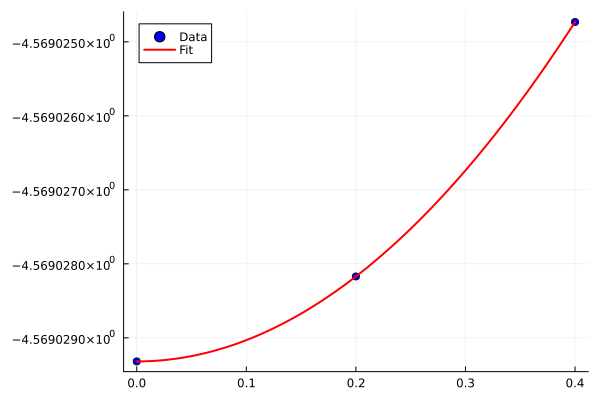

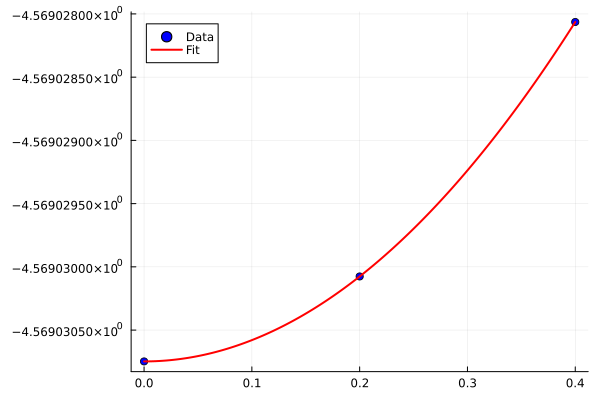

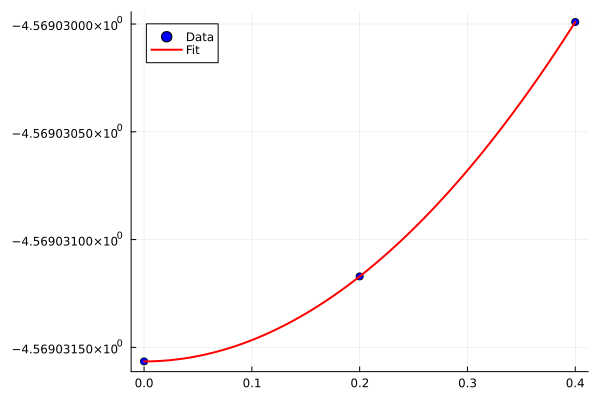

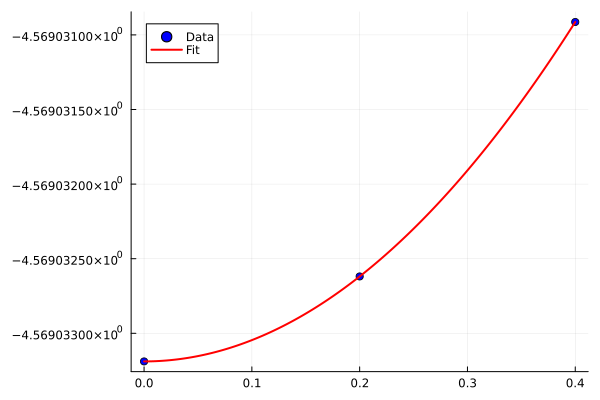

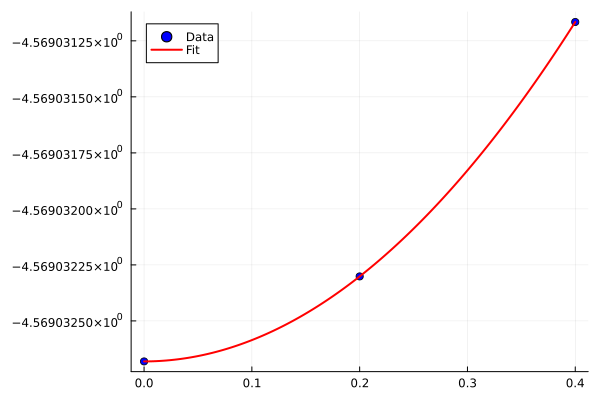

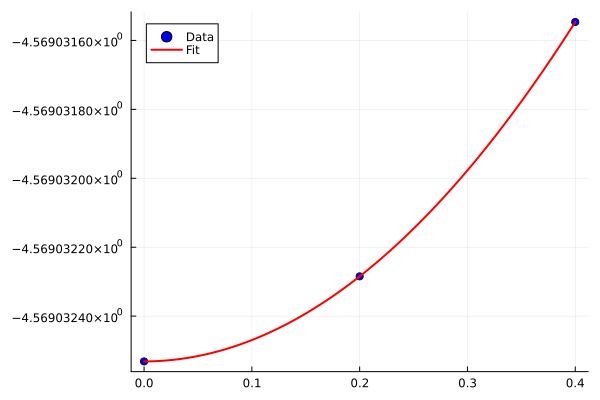

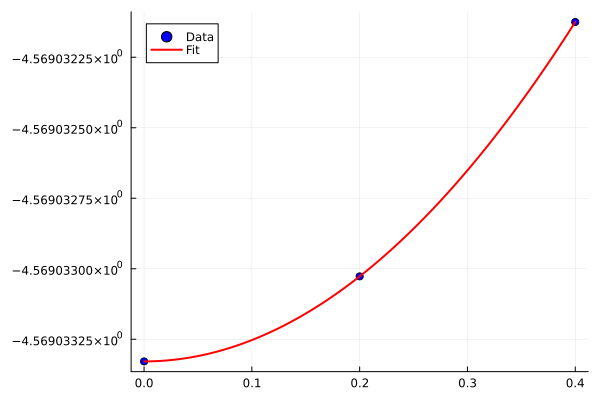

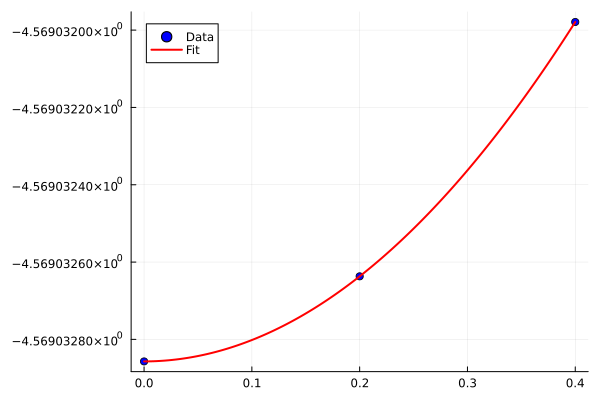

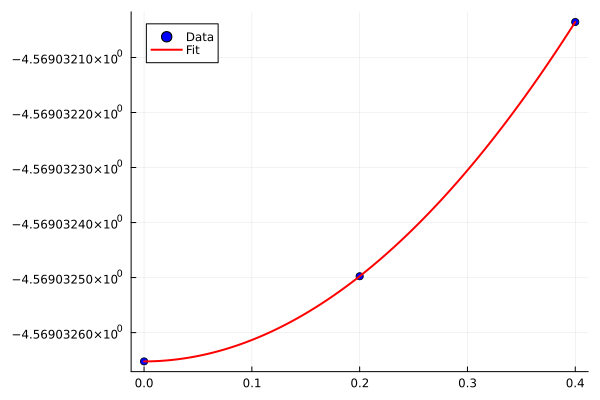

In [75]:
min_list = []
for i in H_meas_indices
    peak = argmin(H_data_tensor[i,:])
    xs = collect(δϕs)[maximum([peak-2,1]):peak+2]; ys = H_data_tensor[i,maximum([peak-2,1]):peak+2];
    
    model(x, p) = p[1]*(x).^2 .+ p[2]*(x) .+ p[3]
    p0 = ones(3)

    fit = curve_fit(model, xs, ys, p0)
    fitted_params = fit.param
    
    xfit = range(minimum(xs), maximum(xs), length=1000)  
    yfit = model(xfit, fitted_params) 

    # Plot the data and the fit
    s = scatter(xs, ys, label="Data", color=:blue, legend=:topleft)
    plot!(xfit, yfit, label="Fit", color=:red, linewidth=2)
    
    push!(min_list,xfit[argmin(yfit)])

    # display(s)
end

### Plotting

When we calculate the energy density, it comes with an arbitrary additive constant. In the following cell, we determine the true zero point of the energy density by finding where the energy density curves coalesce.

In [76]:
δϕs_refined = 0.1:0.01:2*pi-0.1
H_data_tensor_refined = zeros((length(H_meas_indices),length(δϕs_refined)))

for i in 1:length(H_meas_indices)
    H_data_tensor_refined[i,:] = [interpolate_y(δϕs, H_data_tensor[H_meas_indices[i],:], x_new) for x_new in δϕs_refined]
end
    
coal_ind = argmin(vec(maximum(H_data_tensor_refined,dims=1).-minimum(H_data_tensor_refined,dims=1)))

y_shift = mean(H_data_tensor_refined[:,coal_ind]);

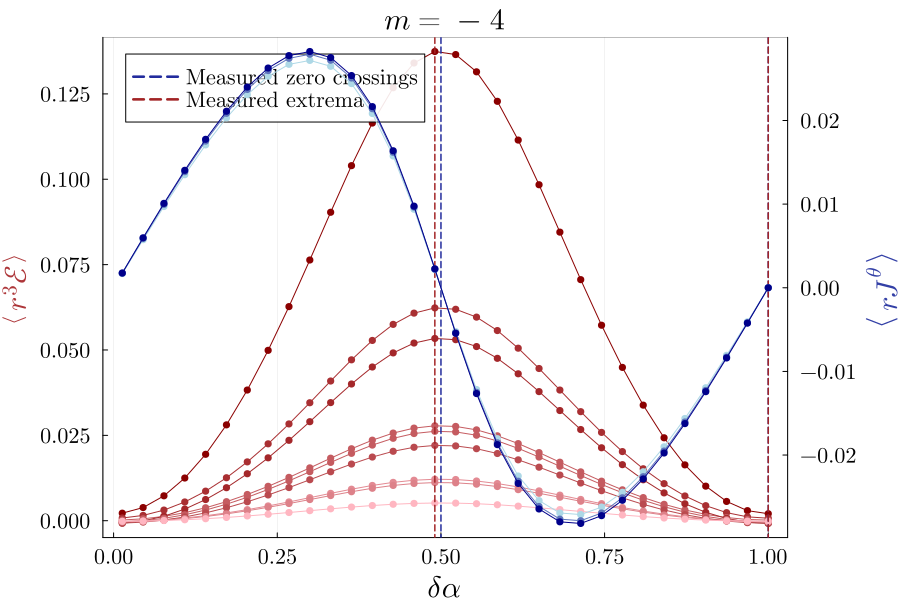

In [77]:
p = plot(size=(900,600),xtickfont=font("Computer Modern", 14), ytickfont=font("Computer Modern", 14), legendfont=font("Computer Modern", 14), guidefont=font("Computer Modern",20), titlefont=font("Computer Modern",20), background_color_legend=RGBA(1,1,1,0.9),legend=:topleft)

title!(latexstring("m = $m"))

x_origin = 26
y_origin = 26

x_meas_s = [H_x_distances[i] for i in H_meas_indices]
y_meas_s = [H_y_distances[i] for i in H_meas_indices]

distances = sqrt.((x_meas_s.-x_origin).^2 .+ ((y_meas_s.-y_origin).^2)')

min_dist = minimum(distances)
max_dist = maximum(distances)

ylabel!(p,L"\left\langle r^3\mathcal{E} \right\rangle")
xlabel!(p,L"\delta\alpha")

max_value = -1e5; min_value = 1e5;

power = 3
for i in H_meas_indices
    x_meas = H_x_distances[i]; y_meas = H_y_distances[i]; 
    distance = sqrt((x_meas-x_origin)^2+(y_meas-y_origin)^2)

    my_color = cgrad(:reds)[(distance-min_dist)/(max_dist-min_dist)]
    plot!(mod.(-δϕs./(2*pi).-1e-9,1),(distance^power).*(H_data_tensor[i,:].-y_shift),label=false,color=my_color,xtickfont=font("Computer Modern", 14), ytickfont=font("Computer Modern", 14), alpha=1.0, yformatter=:plain,yguidefontcolor=cgrad(:reds)[0.7],framestyle=:box)
    scatter!(mod.(-δϕs./(2*pi).-1e-9,1),(distance^power).*(H_data_tensor[i,:].-y_shift),label=false,zcolor=distance,markerstrokewidth=0.0,colormap=:reds, markersize=4,colorbar=false,alpha=1.0)
end

p_twin = twinx(p)

x_origin = 0
y_origin = 0

x_meas_s = [x_distances[i] for i in meas_indices]
y_meas_s = [y_distances[i] for i in meas_indices]

distances = sqrt.((x_meas_s.-x_origin).^2 .+ ((y_meas_s.-y_origin).^2)')

min_dist = minimum(distances)
max_dist = maximum(distances)

ylabel!(p_twin,L"\left\langle rJ^\theta \right\rangle")
xlabel!(p_twin,"")

max_value = -1e5; min_value = 1e5;
for i in meas_indices
    x_meas = x_distances[i]; y_meas = y_distances[i]; 
    distance = sqrt((x_meas-x_origin)^2+(y_meas-y_origin)^2)
    my_color = cgrad(:blues)[(distance-min_dist)/(max_dist-min_dist)]
    plot!(p_twin,mod.(-δϕs./(2*pi).-1e-9,1),-(distance^1).*(data_tensor[i,:]),label=false,color=my_color,legend=false, alpha=1.0, xtickfont=font("Computer Modern", 14), ytickfont=font("Computer Modern", 14), yformatter=:plain, yguidefontcolor=cgrad(:blues)[0.7],guidefont=font("Computer Modern",20))
    scatter!(p_twin,mod.(-δϕs./(2*pi).-1e-9,1),-(distance^1).*(data_tensor[i,:]),label=false,zcolor=distance,markerstrokewidth=0.0,colormap=:blues, markersize=4,colorbar=false, alpha=1.0, xtickfont=font("Computer Modern", 14), ytickfont=font("Computer Modern", 14), yformatter=:plain)
    
    rJθ = -(distance^1).*(data_tensor[i,:]); push!(rJθ,max_value); max_value = maximum(rJθ);
    rJθ = -(distance^1).*(data_tensor[i,:]); push!(rJθ,min_value); min_value = minimum(rJθ);
end

spread = max_value - min_value

## Negative to Positive ##
vline!([1-mean(x_intercept_list)/(2*pi)], linestyle=:dash, color=cgrad(:blues)[0.8], label="Measured zero crossings", lw=1.5)
vline!([1-mean(min_list)/(2*pi)], linestyle=:dash, color=cgrad(:reds)[0.8], label="Measured extrema", lw=1.5)

## Positive to Negative ##
vline!([1-mean(other_x_intercept_list)/(2*pi)], linestyle=:dash, color=cgrad(:blues)[0.8], label=false, lw=1.5)
vline!([1-mean(max_list)/(2*pi)], linestyle=:dash, color=cgrad(:reds)[0.8], label=false, lw=1.5)

plot!(p,left_margin = 2Plots.mm,right_margin = 3Plots.mm)


plot!(p,framestyle=:semi)

display(p)